In [105]:
import subprocess
import sys

# 安装 openpyxl
try:
    import openpyxl
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "openpyxl"])
    import openpyxl  # 重新导入
# 安装 seaborn
try:
    import seaborn
except ModuleNotFoundError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "seaborn"])
    import seaborn  # 重新导入

In [106]:

import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [107]:
df_drivers = pd.read_excel(r'C:/Users/dell/Desktop/simulation/Project/group work/simulation project/drivers (2).xlsx', engine='openpyxl')
df_riders=pd.read_excel(r'C:/Users/dell/Desktop/simulation/Project/group work/simulation project/riders (2).xlsx', engine='openpyxl')
# making sure the column of time is datetime format
df_riders['request_time']=pd.to_datetime(df_riders['request_time'])
df_drivers['arrival_time']=pd.to_datetime(df_drivers['arrival_time'])
# extract hour information of each dataset
df_riders['hour']=df_riders['request_time'].dt.hour
df_drivers['hour'] = df_drivers['arrival_time'].dt.hour
# group riders by hours
rider_counts= df_riders.groupby('hour').size()
# group drivers by hours
driver_counts= df_drivers.groupby('hour').size()

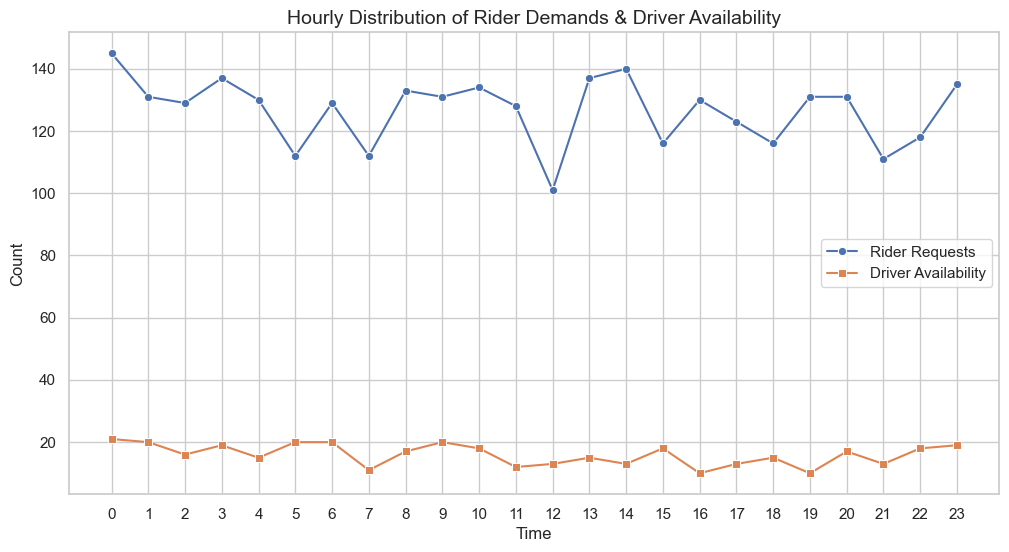

In [108]:
plt.figure(figsize=(12, 6))
# plot the line of distribution of Rider demands
sns.lineplot(x=rider_counts.index, y=rider_counts.values, label="Rider Requests", marker="o")
# plot the line of distribution of Driver available
sns.lineplot(x=driver_counts.index, y=driver_counts.values, label="Driver Availability", marker="s")

plt.title("Hourly Distribution of Rider Demands & Driver Availability", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(range(24))  # X value means the daily hours
plt.legend()
plt.show()


乘客数量大于司机数量，说明供需不平衡，可能导致乘客取消率高
观察高峰期（如早晚通勤时间），并考虑优化策略，如动态定价或司机激励机制

In [109]:
(df_riders['status']).unique()

array(['dropped-off', 'abandoned', 'dropoff-scheduled',
       'pickup-scheduled'], dtype=object)

In [110]:
# statistic canceled orders
total_requests = len(df_riders)
canceled_requests = df_riders['status'].eq('abandoned').sum()
# calculate canceled ratio
cancellation_rate = canceled_requests / total_requests * 100

print(f"Total orders: {total_requests}")
print(f"cancelled order: {canceled_requests}")
print(f"canceled order ratio: {cancellation_rate:.2f}%")



Total orders: 3040
cancelled order: 147
canceled order ratio: 4.84%


计算乘客平均等待时间

In [111]:
# filter 
successful_riders = df_riders[df_riders['status'].str.lower() == 'dropped-off'].copy()

# transform data into datetime
successful_riders['request_time'] = pd.to_datetime(successful_riders['request_time'])
successful_riders['pickup_time'] = pd.to_datetime(successful_riders['pickup_time'])

# calculate the wait time for successful rider
successful_riders['wait_time'] = (successful_riders['pickup_time'] - successful_riders['request_time']).dt.total_seconds() / 60

# 计算平均等待时间
average_wait_time = successful_riders['wait_time'].mean()

print(f"Average wait time for each successfully dropped-off rider: {average_wait_time:.2f} mins")


Average wait time for each successfully dropped-off rider: 20.31 mins


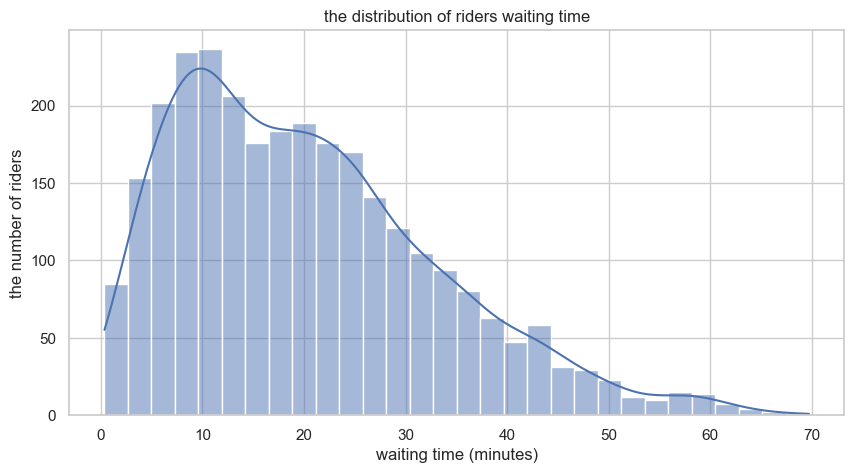

In [112]:

plt.figure(figsize=(10, 5))
sns.histplot(successful_riders['wait_time'], bins=30, kde=True)
plt.xlabel("waiting time (minutes)")
plt.ylabel("the number of riders")
plt.title("the distribution of riders waiting time")
plt.show()


乘客等待时间在8-10分钟是最多的，乘客平均等待时间是20.35分钟
如果等待时间超过 10 分钟，可能需要优化匹配算法（例如更智能的派单）

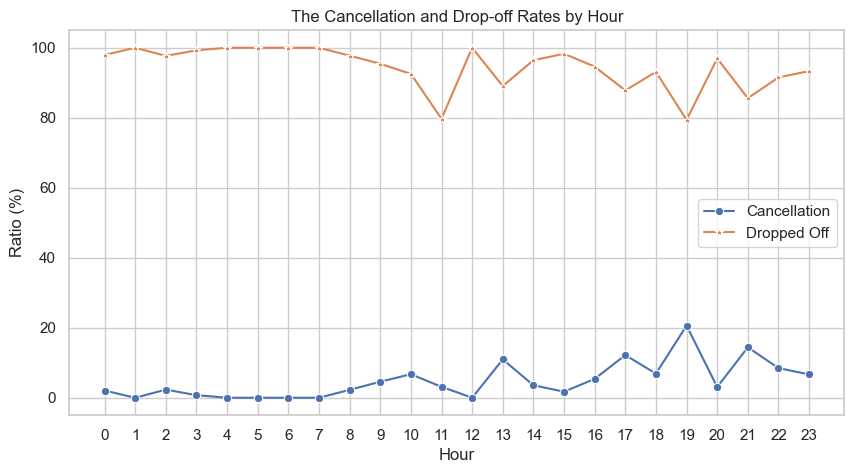

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns

hourly_cancellation = df_riders.groupby('hour')['status'].apply(lambda x: (x.str.lower() == "abandoned").mean() * 100)
hourly_droppedoff = df_riders.groupby('hour')['status'].apply(lambda x: (x.str.lower() == "dropped-off").mean() * 100)

plt.figure(figsize=(10, 5))

sns.lineplot(x=hourly_cancellation.index, y=hourly_cancellation.values, marker="o", label="Cancellation")
sns.lineplot(x=hourly_droppedoff.index, y=hourly_droppedoff.values, marker="*", label="Dropped Off")

plt.xlabel("Hour")
plt.ylabel("Ratio (%)")
plt.title("The Cancellation and Drop-off Rates by Hour")
plt.legend()  
plt.xticks(range(24))  
plt.show()

19点的取消率最高
如果取消率很高（> 20%），说明供需不匹配，可能需要增加司机上线数；
如果高峰时段取消率高，可以考虑动态定价，鼓励司机接单

计算每个行程的司机收入

In [114]:

def parse_coordinates(coord):
   '''
   transform (string, string) into (float, float)
   '''
   if isinstance(coord, str):  # ensure input is string
        coord = coord.replace('(','').replace(')','') # Remove parentheses
        x, y = coord.split(",")  # split string by comma
        return float(x.strip()), float(y.strip())  # delete blank and transform them to float
   else:
       raise ValueError

# transform the pickup location and droppff location for each rider
df_riders[['origin_x', 'origin_y']] = df_riders['pickup_location'].apply(lambda c: pd.Series(parse_coordinates(c)))
df_riders[['dest_x', 'dest_y']] = df_riders['dropoff_location'].apply(lambda c: pd.Series(parse_coordinates(c)))


In [115]:
# euclidean distance from two point
def euclidean_distance(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

# caluate the distance from rider demand location to destination
df_riders['trip_distance'] = df_riders.apply(lambda row: euclidean_distance(row['origin_x'], row['origin_y'], row['dest_x'], row['dest_y']), axis=1)

# calulate the payment £(3 + 2 * trip+distance)
df_riders['fare'] = 3 + (2 * df_riders['trip_distance'])

# calulate the mean earning for each order
df_riders['profit'] = df_riders['fare'] - df_riders['cost']
average_income = df_riders['profit'].mean()

print(f"rider payments: £{average_income:.2f}")

KeyError: 'cost'

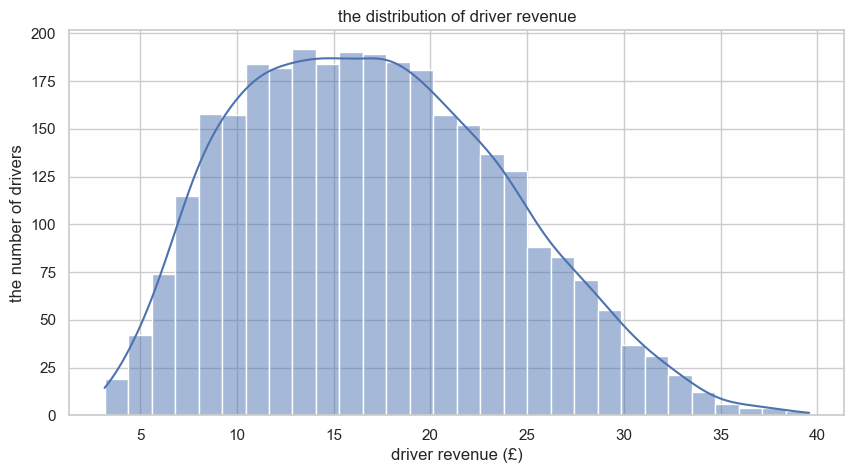

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df_riders['profit'], bins=30, kde=True)
plt.xlabel("driver revenue (£)")
plt.ylabel("the number of drivers")
plt.title("the distribution of driver revenue")
plt.show()

如果曲线呈正态分布，说明收入较均衡。

构建离散事件模拟的基本架构

考虑到乘客匹配逻辑：应考虑“如果有多个等候乘客”
当前代码只尝试匹配第一个等待的乘客，但如果有多个乘客同时在排队，可能会出现某些乘客长期等待的情况。改进方法：

让最近的司机匹配等待时间最长的乘客（FIFO队列）。
如果有多个乘客，按照“等待时间长+距离近”综合排序

In [ ]:
from typing import Callable, List, Dict, Any, Tuple, TYPE_CHECKING
from bisect import bisect_right
import random
import math

print('boxcar_simulation.py loaded successfully')

# Create a Driver class
class Driver:
    def __init__(self, driver_id: int):
        self.id = driver_id  
        self.location = (random.uniform(0, 20), random.uniform(0, 20))  # give a initial location for each driver
        self.availability_time = random.uniform(5, 8)  # generate a available time for each driver
        self.status = 'available'  # initial status is will to accept rider
        self.earnings = 0.0 
        self.total_miles = 0.0 # travel miles for each driver
        self.scheduled_offline = False  # mark as delayed offline
        self.total_active_time = 0.0  # Denote the time spent on pickup and the trip to the destination.

# Create a Rider class
class Rider:
    def __init__(self, rider_id: int):
        self.id = rider_id
        self.pickup_location = (random.uniform(0, 20), random.uniform(0, 20)) # location for pickup
        self.dropoff_location = (random.uniform(0, 20), random.uniform(0, 20)) #locaiton for dropoff
        self.patience = random.expovariate(5)  # patient time for wait a driver accept order
        self.status = 'waiting'
        self.request_time = 0.0 # the time when this rider raise a demand
        self.pickup_time = 0.0  # the time when this rider is picked up        

# Create a TripRecord class, taking down each trip
class TripRecord:
    def __init__(self, rider_id: int, driver_id: int, pickup_distance: float, trip_distance: float):
        # input the rider, driver, the distance from original loc to pickup loc, and distance from pickup loc to destination
        self.rider_id = rider_id
        self.driver_id = driver_id
        self.pickup_distance = pickup_distance
        self.trip_distance = trip_distance
        # self.waiting_time = 0.0 # 没用上
        self.payment = 3 + 2 * trip_distance  # record the payment for each order
        self.driver_cost = 0.2 * (trip_distance + pickup_distance)   # record the fuel cost for each driver
        self.trip_duration = 0.0  # the distance from pickup location to destination
        # self.completed_riders = 0  # 没用上 completed rider in this order
        
    
# Simulation
class Simulation:
    def __init__(self, distributions: Any = None):
        self.simulation_length = 24 * 30 # simulate n days (transfer into hours)
        self.current_time = 0.0
        self.riders: List[Rider] = [] # create a list to store all rider instance (just add without removing)
        self.drivers: List[Driver] = [] # create a list to store all driver instance (just add without removing)
        self.waiting_riders: List[Rider] = [] # cerate a list to temporarily store all waiting riders
        self.active_trips: Dict[int, TripRecord] = {}  # create a dictionary to store all trips
        self.abandoned_riders = 0   # create a label to numerate the abandoned riders
        
        self.total_waiting_time = 0.0 # 所有乘客总等待时间,计算乘客的平均等待时间
        self.total_driver_earnings = 0.0  # 所有司机的总收入,计算司机的平均收入
        self.trip_records: List[TripRecord] = []  # create a list to store all order records
        self.event_calendar: List[Dict[str, Any]] = [] # event calendar
        self.distributions: Dict[str, Callable[[], float]] = {} # create a dict to store all distributions
        self.event_handlers: Dict[str, Callable[[Simulation, Any], None]] = {} # store handler functions for each event type
        self.driver_earnings: Dict[int, float] = {}  # 记录司机收入
        self.driver_trips: Dict[int, int] = {}       # 记录每个司机完成的行程次数(工作量)
        self.completed_riders = 0  # 确保初始化了这个属性

# 建立分布函数---模拟乘客和司机的到达事件
        if distributions:
            self.register_distribution('rider_arrival', distributions.rider_interarrival)  #乘客到达间隔的分布函数
            self.register_distribution('driver_arrival', distributions.driver_interarrival) #司机到达间隔的分布函数
        
        #添加新事件
        self.add_event(self.current_time + self.distributions['rider_arrival'](), 'rider_arrival', None)    #当前时间+当前乘客到达间隔随机时间=乘客何时到达模拟系统(request_time)
        self.add_event(self.current_time + self.distributions['driver_arrival'](), 'driver_available', None) #当前时间+当前司机到达间隔随机时间=司机何时到达模拟系统,同时会在event_calendar添加司机available事件)
        self.add_event(self.simulation_length, 'termination', None)  #模拟总时长

# 确保每个事件按其发生的时间顺序被正确处理
    def add_event(self, event_time: float, event_type: str, event_data: Any = None) -> None: #
        event = {'time': event_time, 'type': event_type, 'data': event_data}
        index = bisect_right([e['time'] for e in self.event_calendar], event_time)
        self.event_calendar.insert(index, event)

#注册分布函数到simulation中    
    def register_distribution(self, name: str, handler: Callable[[], float]) -> None:
        self.distributions[name] = handler

#注册事件处理函数到simulation中
    def register_event_handler(self, event_type: str, handler: Callable[['Simulation', Any], None]) -> None:
        self.event_handlers[event_type] = handler

#推进模拟时间并处理下一个事件
    def progress_time(self) -> None:
        if not self.event_calendar:
            print("No more events to process.") #检查event_calendar是否为空
            return
        
        next_event = self.event_calendar.pop(0)  #更新下一次事件
        self.current_time = next_event['time']   #更新当前模拟事件
        event_type = next_event['type']          #根据事件类型找对应的处理函数
        event_data = next_event['data']          #传入数据处理
        print(f"\n--- Processing {event_type} at {self.current_time:.2f}h ---")    
        
        if event_type in self.event_handlers:   #调用与事件相应的处理函数
            self.event_handlers[event_type](self, event_data)
        else:
            print(f"Warning: No handler for {event_type}")

# 计算基尼系数
    def calculate_gini_coefficient(self, earnings: List[float]) -> float:
        """计算基尼系数来衡量收入分配的公平性"""
        n = len(earnings)
        if n == 0:
            return 0.0  # 如果没有司机，基尼系数为0
        
        # 计算所有收入对之间的绝对差值的总和
        total_diff = sum(abs(x - y) for x in earnings for y in earnings)
        
        # 计算平均收入
        mean_earnings = sum(earnings) / n
        
        # 计算基尼系数
        gini = total_diff / (2 * n**2 * mean_earnings)
        return gini
    
# 运行模拟过程
    def run(self) -> None:
        while self.event_calendar:
            self.progress_time()  #运用progress_time处理下一个事件
            if self.current_time >= self.simulation_length:
                break
    
        print("\n=== Simulation Results ===")
        print(f"Abandoned Riders: {self.abandoned_riders}") #放弃乘车的乘客数量
        print(f"Completed Riders: {self.completed_riders}")
        print(f"Avg Waiting Time: {self.total_waiting_time / len(self.riders) if self.riders else 0:.2f}h")   #乘客的平均等待时间
        print(f"Total Driver Earnings: £{self.total_driver_earnings:.2f}")  #所有司机的总收入
    
       
    #评估drivers的满意度:
        # 计算司机时薪的中位数
        driver_hourly_earnings = [ self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]
        if driver_hourly_earnings:
            median_hourly_earnings = np.median(driver_hourly_earnings)
            print(f"Median Hourly Earnings: £{median_hourly_earnings:.2f}")
        else:
            print("No valid active time for calculating median hourly earnings.")

        #公平性指标1: 标准差衡量司机每小时收入
        earnings = list(self.driver_earnings.values()) #获取所有司机收入
        if len(earnings) > 1:
            mean = sum(earnings) / len(earnings)
            variance = sum((x - mean)**2 for x in earnings) / len(earnings)
            std_dev = math.sqrt(variance)
            print(f"Driver Earnings Std Dev: £{std_dev:.2f}")

        #公平性指标2: 计算基尼系数
        gini = self.calculate_gini_coefficient(earnings)
        print(f"Gini Coefficient for Driver Earnings: {gini:.4f}")
        
        # 计算司机的平均时薪--评估司机的工作负荷
        total_driver_hours = sum(driver.total_active_time for driver in sim.drivers)
        if total_driver_hours > 0:
           avg_hourly_earnings = self.total_driver_earnings / total_driver_hours
           print(f"Average Driver Earnings per Hour: £{avg_hourly_earnings:.2f}")
        else:
           print("No active hours to calculate earnings.")
        
        # 计算每个司机的时薪，并计算所有司机时薪的平均值
        driver_hourly_earnings = [self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]

        if driver_hourly_earnings:
          avg_hourly_earnings_2 = sum(driver_hourly_earnings) / len(driver_hourly_earnings)
          print(f"Average Driver Earnings per Hour (based on individual hourly earnings): £{avg_hourly_earnings_2:.2f}")
        else:
          print("No active hours to calculate earnings.")

           
        #计算平均休息时间
        if self.drivers: #检查是否有司机,避免在没有司机情况下计算平均休息时间
            avg_rest_time = sum(d.availability_time - d.total_active_time for d in self.drivers) / len(self.drivers) #在线时间-实际工作时间(接到乘客)
            print(f"Average Driver Rest Time: {avg_rest_time:.2f} hours")
    
    #评估Riders的满意度
        #记录乘客的等待时间分布
        waiting_times = [r.pickup_time - r.request_time for r in sim.riders if r.status == "in_progress"] #确保只计算那些正在进行行程中的乘客
        if waiting_times: #检查等待时间列表是否为空,如果非空继续执行
            median_wait = sorted(waiting_times)[len(waiting_times) // 2]
            percentile_95_wait = sorted(waiting_times)[int(len(waiting_times) * 0.95)] #所有乘客中最迟的5%的乘客的等待时间,这个值表示大约95%的乘客的等待时间小于或等于这个时间            
            print(f"Median Wait Time: {median_wait:.2f}h")
            print(f"95th Percentile Wait Time: {percentile_95_wait:.2f}h")
        
        # 订单完成率(完成和取消)---前面已知放弃乘车的乘客数量
        total_riders = len(self.riders)
        completed_riders = total_riders - self.abandoned_riders
        completion_rate = completed_riders / total_riders if total_riders > 0 else 0
        print(f"Completed Riders: {completed_riders}")
        print(f"Abandoned Riders: {self.abandoned_riders}")
        print(f"Order Completion Rate: {completion_rate:.2%}")

    #运营效率的评估
        #指标1:车辆利用率--
        if self.drivers:
            total_active_time = sum(driver.total_active_time for driver in self.drivers)
            total_availability_time = sum(driver.availability_time for driver in self.drivers)
            vehicle_utilization = total_active_time / total_availability_time if total_availability_time > 0 else 0
            print(f"Vehicle Utilization: {vehicle_utilization:.2%}")
        
        #指标2: 统计所有乘客平均行程时间--评估乘客的整体出行效率和系统调度的效果
        if self.trip_records:
            total_trip_duration = sum(record.trip_duration for record in self.trip_records)
            avg_trip_duration = total_trip_duration / len(self.trip_records)
            print(f"Average Trip Duration: {avg_trip_duration:.2f} hours")
        else:
            print("No trip records available to calculate average trip duration.")

# Calculate the euclidean distance between two point
def euclidean_distance(loc1: tuple, loc2: tuple) -> float:
    '''
    Calculate the euclidean distance between two point
    '''
    return math.sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

# #模拟处理司机到达乘客上车点事件-接乘客
# def handle_pickup_complete(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
#     """处理司机到达乘客上车点事件"""
#     driver, rider, pickup_time = event_data # 从event_data将driver,rider和pickup_time属性取出
#     rider.pickup_time = sim.current_time # 乘客被接走的时间点
#     rider.status = "in_progress"

#     # 计算行程距离和时间
#     trip_distance = euclidean_distance(rider.pickup_location, rider.dropoff_location) #利用欧几里得算行程距离
#     mu_trip = trip_distance / 20  # 司机开车平均速度20mph----生成理想的每次行程时间数据  
#     trip_time = random.uniform(0.8 * mu_trip, 1.2 * mu_trip)  # 由于时间的随机性----模拟生成现实中每次行程的时间数据

#     # 安排行程结束事件
#     sim.add_event(sim.current_time + trip_time, "trip_end", (driver, rider, trip_distance,pickup_time)) #行程结束后，处理行程的结算（计算司机的收入、更新司机乘客的状态等）

# #模拟行程结束后事件-更新最新数据
# def handle_trip_end(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
#     """处理行程结束事件"""
#     driver, rider, trip_distance, pickup_time = event_data
#     # 更新司机状态和位置
#     driver.status = "available"
#     driver.location = rider.dropoff_location  # 司机移动到目的地

#     # 添加完成状态更新
#     rider.status = 'completed'
#     sim.completed_riders += 1
#     sim.total_waiting_time += (rider.pickup_time - rider.request_time)

#     # 计算收入和成本
#     pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 计算接客距离
#     payment = 3 + 2 * trip_distance  # £3初始费用 + £2/英里
#     driver_cost = 0.2 * (trip_distance+ pickup_distance)  # £0.2/英里油费
#     driver.earnings += (payment - driver_cost) #司机的净收入
#     sim.total_driver_earnings += (payment - driver_cost) #更新整个模拟系统中总司机的净收入
#     # 更新司机收入和服务次数
#     sim.driver_earnings[driver.id] = driver.earnings #将当前司机的收入更新到driver.earnings中
#     sim.driver_trips[driver.id] = sim.driver_trips.get(driver.id, 0) + 1 #更新司机的服务次数(司机已完成的行程数量)

#     # 记录等待时间--累加记录系统用于后面计算平均等待时间
#     sim.total_waiting_time += (rider.pickup_time - rider.request_time)
#     # 生成行程记录
#     pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 接客距离
#     trip_record = TripRecord(rider.id, driver.id, pickup_distance, trip_distance) #创建新的行程记录对象
#     trip_record.trip_duration = sim.current_time - rider.pickup_time  #记录行程时长(接到乘客到行程结束)
#     sim.trip_records.append(trip_record) #保留行程所有数据

#     # 司机重新可用后尝试匹配等待中的乘客
#     if sim.waiting_riders:
#         next_rider = sim.waiting_riders[0]  #等待中的第一个乘客
#         match_rider_to_driver(sim, next_rider)  #调用匹配函数将司机与该乘客匹配，开始新的行程

#     # 检查司机是否需要离线
#     if driver.scheduled_offline:
#         driver.scheduled_offline = False #如果司机离线
#         sim.add_event(sim.current_time, "driver_offline", driver) #添加一个司机离线事件,表示已有一名司机下线

#     # 计算行程时间
#     trip_time = random.uniform(0.8 * (trip_distance / 20), 1.2 * (trip_distance / 20))
#     driver.total_active_time += pickup_time + trip_time  # 更新司机的活跃时间(记录司机活跃时间)--包括接乘客和行使的时间,方便后面计算车辆利用率的指标以及平均休息时间

# #司机与乘客的匹配
# def match_rider_to_driver(sim: Simulation, rider: Rider):
#     """匹配最近的可用司机"""
#     available_drivers = [d for d in sim.drivers if d.status == "available"] #从drivers list里面选出当前状态为available的driver
#     if not available_drivers:
#         print(f"乘客{rider.id} No driver available. Keep waiting...")
#         return
    
#     # 计算所有可用司机到乘客的接客距离，按升序排序,将离乘客距离最近的司机匹配上
#     available_drivers.sort(
#         key=lambda d: euclidean_distance(d.location, rider.pickup_location)
#     )
    
#     # 选择最近的司机（排序后第一个元素）
#     closest_driver = available_drivers[0]
    
#     # 更新司机和乘客状态
#     closest_driver.status = "occupied"
#     if rider in sim.waiting_riders:
#         sim.waiting_riders.remove(rider) #将已匹配的乘客移除'等待中的乘客列表'外
#     rider.status = "matched"
    
#     # 计算接客时间和距离
#     pickup_distance = euclidean_distance(closest_driver.location, rider.pickup_location)
#     mu_pickup = pickup_distance / 20  # 平均速度20mph
#     pickup_time = random.uniform(0.8 * mu_pickup, 1.2 * mu_pickup)  # 时间随机性
    
#     # 安排接客完成事件--存入event_calendar(按时间顺序)
#     sim.add_event(
#         sim.current_time + pickup_time, 
#         "pickup_complete", 
#         (closest_driver, rider, pickup_time)
#     )

# # 乘客到达事件---乘客的到达和等待
# def handle_rider_arrival(sim: Simulation, event_data: Any) -> None:
#     rider_id = len(sim.riders) + 1 #为每个新乘客分配id
#     origin = (random.uniform(0, 20), random.uniform(0, 20)) #随机生成请求乘车的地点
#     destination = (random.uniform(0, 20), random.uniform(0, 20))
#     rider = Rider(rider_id, origin, destination)   #创建新的rider对象
#     rider.request_time = sim.current_time 
#     sim.riders.append(rider)  #加入所有乘客列表
#     sim.waiting_riders.append(rider) #加入等待列表
#     # 安排乘客超时事件
#     sim.add_event(sim.current_time + rider.patience, "rider_timeout", rider)  
#     sim.add_event(sim.current_time + sim.distributions["rider_arrival"](), "rider_arrival") #安排下一次乘客到达事件
#     # 立即尝试匹配
#     match_rider_to_driver(sim, rider)

# #乘客等待超时事件--如果在未来的时间点触发了安排下一位乘客到达,此函数会检测到上一个rider还处于waiting的状态,超时了即放弃
# def handle_rider_timeout(sim: Simulation, rider: Rider):
#     if rider.status == 'waiting':
#         rider.status = 'abandoned'
#         sim.abandoned_riders += 1 #放弃乘客数量+1
#         sim.waiting_riders.remove(rider) #将放弃等待的乘客从等待列表中移除

# #司机可用事件
# def handle_driver_available(sim: Simulation, event_data: Any) -> None:
#     driver_id = len(sim.drivers) + 1
#     driver = Driver(driver_id) #创建新的driver对象-new driver
#     sim.drivers.append(driver) #将创建的司机加入新列表,表示该司机加入了系统并准备接受任务
#     # 司机离线时间处理
#     planned_offline_time = sim.current_time + driver.availability_time #司机上线后的工作时间
#     sim.add_event(planned_offline_time, "driver_offline", driver) # 添加一个离线事件,标明司机下线
#     sim.add_event(sim.current_time + sim.distributions["driver_arrival"](), "driver_available") #安排下一个司机到达
#     # 司机上线后立即尝试匹配
#     if sim.waiting_riders: #是否有等待中的乘客
#         next_rider = sim.waiting_riders[0] #当前最早等待的乘客
#         match_rider_to_driver(sim, next_rider)

# def handle_driver_offline(sim: Simulation, event_data: Driver) -> None:
#     """处理司机离线事件（状态检查）"""
#     if event_data.status == "occupied":
#         event_data.scheduled_offline = True  # 标记延迟离线,该司机计划在当前行程结束后离线
#         print(f"司机{event_data.id}正在服务中，将在行程结束后离线")
#     else:
#         event_data.status = "offline"
#         sim.drivers.remove(event_data)
#         print(f"司机 {event_data.id} 已立即下线")

# class Distributions:
#     def __init__(self):
#         pass  # 存储模拟对象（如果需要的话）
    
#     def rider_interarrival(self) -> float:
#         """生成乘客到达间隔的时间（基于指数分布）"""
#         rate = 30  # λ (rate parameter for passenger arrival)
#         interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
#         return interarrival_time
    
#     def driver_interarrival(self) -> float:
#         """生成司机到达间隔的时间（基于指数分布）"""
#         rate = 5  # λ (rate parameter for driver arrival)
#         interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
#         return interarrival_time
    
# # 注册事件处理器-作用:模拟系统会将每个事件与它对应的事件处理函数绑定。当事件发生时,系统会自动调用相应的处理函数，更新模拟状态
# sim = Simulation(distributions=Distributions())
# sim.register_event_handler("rider_arrival", handle_rider_arrival) #当乘客到达时，调用 handle_rider_arrival 处理函数
# sim.register_event_handler("driver_available", handle_driver_available) #当司机变为可用时，调用 handle_driver_available 处理函数
# sim.register_event_handler("trip_end", handle_trip_end) #当行程结束时，调用 handle_trip_end 处理函数
# sim.register_event_handler("rider_timeout", handle_rider_timeout) #当乘客等待超时时，调用 handle_rider_timeout 处理函数
# sim.register_event_handler("driver_offline", handle_driver_offline) #当司机下线时，调用 handle_driver_offline 处理函数
# sim.register_event_handler("termination", lambda sim, event_data: print("Simulation terminated.")) #模拟结束时，输出 "Simulation terminated
# sim.register_event_handler("pickup_complete", handle_pickup_complete) #当司机接到乘客时，调用 handle_pickup_complete 处理函数


# # 验证分布的测试函数--确保模拟的随机事件符合预期的统计规律
# def test_distributions():
#     # 验证乘客到达间隔
#     samples = [random.expovariate(30) for _ in range(10000)]
#     avg = sum(samples)/len(samples)
#     print(f"\n[分布验证] 乘客到达间隔均值: {avg:.4f}h (理论值: {1/30:.4f}h)")

#     # 验证司机在线时间
#     samples = [random.uniform(5,8) for _ in range(10000)]
#     avg = sum(samples)/len(samples)
#     print(f"[分布验证] 司机在线时间均值: {avg:.2f}h (理论值: 6.50h)")
def handle_pickup_complete(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    """
    handle pickup complement 
    1. update rider's status and record this moment
    2. calculate the trip time and add destination event
    """
    driver, rider, pickup_duration = event_data # get attributes from input event_data
    rider.pickup_time = sim.current_time # record the time when starting journery
    rider.status = "in_progress" # update rider'status

    # calculate this trip duration time
    trip_route = euclidean_distance(rider.pickup_location, rider.dropoff_location)
    mu_trip = trip_route / 20
    trip_duration = random.uniform(0.8 * mu_trip, 1.2 * mu_trip) 

    # add trip_end event 
    sim.add_event(sim.current_time + trip_duration, "trip_end", (driver, rider, trip_route, pickup_duration, trip_duration)) 


def handle_trip_end(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    '''
    1. calculate the payment and cost for this trip
    2. record the data for individual and entire system
    3. update the status for this driver and this rider
    4. generate TripRecord for this order
    5. if possible, we assign this driver a new rider, before this, we need to check if this driver need a break
    '''
    tmpt_driver, tmpt_rider, trip_route, pickup_duration, trip_duration = event_data

    # calculate the pickup distance, we use the driver's last location and rider's request location to 
    # measure the distacne for pickup route
    pickup_route = euclidean_distance(tmpt_driver.location, tmpt_rider.pickup_location)  
    # calculate the payment for this order and fuel cost
    payment = 3 + 2 * trip_route  # base fare plus per mile charge
    driver_cost = 0.2 * (trip_route+ pickup_route)  # fuel cost for total route
    tmpt_driver.earnings += (payment - driver_cost) # pure earning for this trip
    sim.total_driver_earnings += (payment - driver_cost) # update the pure earning in simulation system

    # update earning and service time for driver instance 
    sim.driver_earnings[tmpt_driver.id] = tmpt_driver.earnings 
    sim.driver_trips[tmpt_driver.id] = sim.driver_trips.get(tmpt_driver.id, 0) + 1 
    
    # record total waiting time for this rider
    sim.total_waiting_time += (tmpt_rider.pickup_time - tmpt_rider.request_time)

    trip_record = TripRecord(tmpt_rider.id, tmpt_driver.id, pickup_route, trip_route) # create new instance of trip record
    tmpt_driver.total_active_time += pickup_duration + trip_duration  # 
    
    sim.trip_records.append(trip_record) # store in a list

    # check this driver whether need to offline
    if tmpt_driver.scheduled_offline:
        sim.add_event(sim.current_time, "driver_offline", tmpt_driver) # add a offline event into calendar and this monment as happend time.
        return

    # update this driver's status
    tmpt_driver.status = "available"
    tmpt_driver.location = tmpt_rider.dropoff_location # update the driver's location

    # update this rider's status
    tmpt_rider.status = 'completed'
    sim.completed_riders += 1

    # After finishing this order we switch driver's data and seek the availble rider
    # TRY to MATCH
    if sim.waiting_riders: # if there is a rider waiting
        # descending order the distance of driver's location and pickup location of each waiting rider
        # match the closest rider
        sorted_riders = sorted(sim.waiting_riders, key=lambda r: euclidean_distance(tmpt_driver.location, r.pickup_location))
        closest_rider = sorted_riders[0]
        match_rider_to_driver(sim, closest_rider) # update status and manage next event

    # check this driver whether need to offline
    # if tmpt_driver.scheduled_offline:
    #     tmpt_driver.scheduled_offline = False
    #     sim.add_event(sim.current_time, "driver_offline", tmpt_driver) # add a offline event into calendar and this monment as happend time.

    # record the total working time in this order
    # tmpt_driver.total_active_time += pickup_duration + trip_duration  # update actice time for driver


def match_rider_to_driver(sim: Simulation, rider: Rider):
    """
    match the closest driver for driver
    1. We need to seek available drivers in dict.driver and sort up to find the closest one.
    2. Update the status of this lucky driver and input rider
    3. add this new event into calendar(the time when finishing pickup)
    """
    available_drivers = [d for d in sim.drivers if d.status == "available"] # formulate a list to seek the available driver
    if not available_drivers:
        print(f"For rider{rider.id}. No driver available. Keep waiting...")
        return
    
    # calculate the distance between input rider and all instance in dict
    available_drivers.sort(key=lambda d: euclidean_distance(d.location, rider.pickup_location))
    
    # select the closet driver in available list
    closest_driver = available_drivers[0]
    
    # update the status of rider and driver
    if rider in sim.waiting_riders:
        sim.waiting_riders.remove(rider) # remove input rider from waiting list
    closest_driver.status = "occupied" # update driver's and rider's status
    rider.status = "matched"
    
    # calculate the pickup time (random)
    pickup_distance = euclidean_distance(closest_driver.location, rider.pickup_location)
    mu_pickup = pickup_distance / 20  
    pickup_duration = random.uniform(0.8 * mu_pickup, 1.2 * mu_pickup)
    
    # add new event in calendar
    sim.add_event(
        sim.current_time + pickup_duration, 
        "pickup_complete", 
        (closest_driver, rider, pickup_duration)
    )


def handle_rider_arrival(sim: Simulation,event_data: Any) -> None:
    '''
    handle a new rider arrived, create an instance of the Rider class
    1. create an instance of the Rider class
    2. add this new rider into waiting list and rider dict
    3. add the timeout event for this rider and 
    4. try to match a driver
    '''
    rider_id = len(sim.riders) + 1 # find index through length of dict
    new_rider = Rider(rider_id)   # create a new instance
    new_rider.request_time = sim.current_time # record request time point
    sim.riders.append(new_rider)  # add into rider list 
    sim.waiting_riders.append(new_rider) # add into waiting list
    
    # add timeout event and next arrival for next rider
    sim.add_event(sim.current_time + new_rider.patience, "rider_timeout", new_rider)  
    sim.add_event(sim.current_time + sim.distributions["rider_arrival"](), "rider_arrival")
    # try to match a driver
    match_rider_to_driver(sim, new_rider)



def handle_rider_timeout(sim: Simulation, leaving_rider: Rider):
    '''
    handle a rider when the waiting time surpasses patience time
    '''
    if leaving_rider.status == 'waiting':
        leaving_rider.status = 'abandoned'
        sim.abandoned_riders += 1 # record these unsatisfied riders
        sim.waiting_riders.remove(leaving_rider) # remove this one from waiting list

def handle_driver_available(sim: Simulation, event_data: Any) -> None:
    '''
    handle a new driver being available, create an instance of the Driver class
    add a event for next driver becoming available and add a event for this driver becoming offline

    '''
    driver_id = len(sim.drivers) + 1
    new_driver = Driver(driver_id) # create an instance of the Driver class
    sim.drivers.append(new_driver) # put this instance in dict

    # add new events for offline of this driver and arrival of next driver
    # offline event
    planned_offline_time = sim.current_time + new_driver.availability_time 
    sim.add_event(planned_offline_time, "driver_offline", new_driver) # add event in calendar

    sim.add_event(sim.current_time + sim.distributions["driver_arrival"](), "driver_available") # add next driver availble event in calendar
    # assign a rider to new driver

    if sim.waiting_riders: # if there is a rider waiting
        # descending order the distance of driver's location and pickup location of each waiting rider
        # match the closest rider
        sorted_riders = sorted(sim.waiting_riders, key=lambda r: euclidean_distance(new_driver.location, r.pickup_location))
        closest_rider = sorted_riders[0]
        match_rider_to_driver(sim, closest_rider) # update status and manage next event

def handle_driver_offline(sim: Simulation, offline_driver: Driver) -> None:
    """
    check the status of each driver
    If this driver was serving a rider, he would postpone the offline time
    """
    if offline_driver.status == 'occupied':
        offline_driver.scheduled_offline = True  # Mark as delayed offline, the driver plans to go offline after the current trip ends
        print(f"driver{offline_driver.id}is serving, after this jounery this driver will offline")
    else:
        offline_driver.status = 'offline' # turnning to offline
        # sim.drivers.remove(offline_driver)
        print(f"driver {offline_driver.id} is going to be offline")

class Distributions:
    def __init__(self):
        pass  
    
    def rider_interarrival(self) -> float:
        '''
        Generate a ReuqestTime for each Rider, lambda = 30
        '''
        rate = 32  # λ (rate parameter for passenger arrival)
        interarrival_time = random.expovariate(rate)  # Generate exponential RV
        return interarrival_time
    
    def driver_interarrival(self) -> float:        
        '''
        Generate a AvailableTime for each Rider, lambda = 3
        '''
        rate = 5  # λ (rate parameter for driver arrival)
        interarrival_time = random.expovariate(rate)  # Generate exponential RV 
        return interarrival_time
    
# 注册事件处理器-作用:模拟系统会将每个事件与它对应的事件处理函数绑定。当事件发生时,系统会自动调用相应的处理函数，更新模拟状态
sim = Simulation(distributions=Distributions())
sim.register_event_handler("rider_arrival", handle_rider_arrival) #当乘客到达时，调用 handle_rider_arrival 处理函数
sim.register_event_handler("driver_available", handle_driver_available) #当司机变为可用时，调用 handle_driver_available 处理函数
sim.register_event_handler("trip_end", handle_trip_end) #当行程结束时，调用 handle_trip_end 处理函数
sim.register_event_handler("rider_timeout", handle_rider_timeout) #当乘客等待超时时，调用 handle_rider_timeout 处理函数
sim.register_event_handler("driver_offline", handle_driver_offline) #当司机下线时，调用 handle_driver_offline 处理函数
sim.register_event_handler("termination", lambda sim, event_data: print("Simulation terminated.")) #模拟结束时，输出 "Simulation terminated
sim.register_event_handler("pickup_complete", handle_pickup_complete) #当司机接到乘客时，调用 handle_pickup_complete 处理函数


# 验证分布的测试函数--确保模拟的随机事件符合预期的统计规律
def test_distributions():
    # 验证乘客到达间隔
    samples = [random.expovariate(30) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"\n[分布验证] 乘客到达间隔均值: {avg:.4f}h (理论值: {1/30:.4f}h)")

    # 验证司机在线时间
    samples = [random.uniform(5,8) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"[分布验证] 司机在线时间均值: {avg:.2f}h (理论值: 6.50h)")


# 主程序 
if __name__ == "__main__":
    test_distributions()  # 分布验证
    sim.run()

boxcar_simulation.py loaded successfully

[分布验证] 乘客到达间隔均值: 0.0333h (理论值: 0.0333h)
[分布验证] 司机在线时间均值: 6.52h (理论值: 6.50h)

--- Processing rider_arrival at 0.01h ---
For rider1. No driver available. Keep waiting...

--- Processing rider_timeout at 0.02h ---

--- Processing rider_arrival at 0.03h ---
For rider2. No driver available. Keep waiting...

--- Processing rider_arrival at 0.05h ---
For rider3. No driver available. Keep waiting...

--- Processing rider_arrival at 0.07h ---
For rider4. No driver available. Keep waiting...

--- Processing rider_arrival at 0.14h ---
For rider5. No driver available. Keep waiting...

--- Processing rider_arrival at 0.14h ---
For rider6. No driver available. Keep waiting...

--- Processing rider_timeout at 0.19h ---

--- Processing rider_arrival at 0.21h ---
For rider7. No driver available. Keep waiting...

--- Processing rider_timeout at 0.21h ---

--- Processing rider_arrival at 0.27h ---
For rider8. No driver available. Keep waiting...

--- Processing r


<br>供需失衡严重

<br>放弃率32.4%（229/(441+229)）表明高峰时段运力不足

<br>95%分位等待时间达62分钟远超行业可接受水平（通常<30分钟）

<br>车辆利用率仅43%显示非高峰时段运力闲置

<br>司机收入两极分化

<br>标准差£48.71显示头部司机收入远超均值

<br>基尼系数0.2虽属合理范围，但结合每小时收入中位数£20.34与平均£94.62的差异，显示存在"超级司机"现象

<br>系统时空匹配低效

<br>平均等待时间17分钟 vs 中位数25分钟，说明短途订单匹配快、长途订单匹配慢

<br>3.84小时平均休息时间与43%利用率矛盾，反映调度算法时空预测能力不足

----蒙特卡洛模拟----
以下代码是实验和结果分析
通过这些 实验和分析，你可以获得仿真系统在不同条件下的 表现数据。
目的是 优化调度策略，提高 司机与乘客的匹配效率，并确保 收入分配公平。
最终目标是 提升仿真系统的综合表现，并为实际运营提供决策支持。

In [ ]:
def run_experiment(driver_rate: float, rider_rate: float, num_runs: int = 5) -> List[Dict]:
    """运行多次实验并收集结果"""
    results = []
    
    # TestDistributions: 定义实验中使用的分布
    class TestDistributions:
        def __init__(self, d_rate: float, r_rate: float):
            self.driver_rate = d_rate
            self.rider_rate = r_rate
            
        def driver_interarrival(self) -> float:
            return random.expovariate(self.driver_rate)
            
        def rider_interarrival(self) -> float:
            return random.expovariate(self.rider_rate)
    
    for run in range(num_runs):
        print(f"\nRunning experiment {run + 1}/{num_runs}")
        print(f"Driver rate: {driver_rate}/hour, Rider rate: {rider_rate}/hour")
        
        # 创建新的模拟实例
        test_distributions = TestDistributions(driver_rate, rider_rate)
        sim = Simulation(distributions=test_distributions)
        
        # 注册所有事件处理器
        sim.register_event_handler("rider_arrival", handle_rider_arrival)
        sim.register_event_handler("driver_available", handle_driver_available)
        sim.register_event_handler("trip_end", handle_trip_end)
        sim.register_event_handler("rider_timeout", handle_rider_timeout)
        sim.register_event_handler("driver_offline", handle_driver_offline)
        sim.register_event_handler("pickup_complete", handle_pickup_complete)
        sim.register_event_handler("termination", lambda sim, event_data: None)
        
        # 添加初始事件
        sim.add_event(sim.current_time + sim.distributions['rider_arrival'](), 'rider_arrival', None)
        sim.add_event(sim.current_time + sim.distributions['driver_arrival'](), 'driver_available', None)
        sim.add_event(sim.simulation_length, 'termination', None)
        
        # 运行模拟
        sim.run()
        
        # 收集并打印每次运行的详细结果
        if sim.drivers and sim.trip_records:
            total_driver_hours = sum(driver.availability_time for driver in sim.drivers)
            avg_hourly_earnings = sim.total_driver_earnings / total_driver_hours if total_driver_hours > 0 else 0
            
            total_active_time = sum(driver.total_active_time for driver in sim.drivers)
            total_availability_time = sum(driver.availability_time for driver in sim.drivers)
            vehicle_utilization = total_active_time / (total_availability_time + 1e-8)
            
            total_riders = len(sim.riders)
            valid_riders = len([r for r in sim.riders if r.status != 'waiting'])
            completion_rate = (valid_riders - sim.abandoned_riders) / valid_riders if valid_riders > 0 else 0
            
                    # 收入分布统计
            earnings = [d.earnings for d in sim.drivers if d.earnings > 0]
            hourly_earnings = [d.earnings / (d.total_active_time + 1e-8)  # 防止除零
                                for d in sim.drivers 
                                if d.total_active_time > 0]
            
            # 等待时间分位数计算
            wait_times = sorted([r.wait_time for r in sim.riders if r.status == 'completed'])
            median_wait = np.median(wait_times) if wait_times else 0
            p95_wait = np.percentile(wait_times, 95) if len(wait_times) >=5 else 0
            
            # 司机休息时间计算
            rest_times = [d.availability_time - d.total_active_time for d in sim.drivers]
            avg_rest = np.mean(rest_times) if rest_times else 0
            
            # 基尼系数计算函数
            def gini_coefficient(values):
                if len(values) == 0 or np.sum(values) == 0:
                    return 0.0
                sorted_values = np.sort(values)
                n = len(values)
                index = 2 * np.arange(1, n+1) - n - 1
                return np.sum(index * sorted_values) / (n * np.sum(sorted_values))
            completed_or_abandoned = [r for r in sim.riders if r.status in ('completed', 'abandoned')]
            run_results = {
                            'run': run + 1,
                            'driver_rate': driver_rate,
                            'rider_rate': rider_rate,
                            'avg_hourly_earnings': avg_hourly_earnings,
                            'vehicle_utilization': vehicle_utilization,
                            'completion_rate': completion_rate,
                            'avg_waiting_time': sim.total_waiting_time / len(completed_or_abandoned) if completed_or_abandoned else 0,
                            'abandoned_rate': sim.abandoned_riders / total_riders if total_riders > 0 else 0,
                            'total_trips': len(sim.trip_records),
                            'total_drivers': len(sim.drivers),
                            'total_riders': total_riders,
                            # 修正后的新增指标
                            'median_hourly_earnings': np.median(hourly_earnings) if len(hourly_earnings) > 0 else 0.0,
                            'gini_coefficient': gini_coefficient(earnings) if len(earnings) > 0 else 0.0,
                            'median_wait_time': median_wait if len(wait_times) > 0 else 0.0,
                            'p95_wait_time': np.percentile(wait_times, 95, method='linear') if len(wait_times) >= 1 else 0.0,
                            'avg_rest_time': np.mean(rest_times) if len(rest_times) > 0 else 0.0,
                            'trip_duration_avg': np.mean([t.trip_duration for t in sim.trip_records]) if sim.trip_records else 0.0,
                            'earnings_std': np.std(earnings) if len(earnings) > 0 else 0.0,
                            'completed_riders': len([r for r in sim.riders if r.status == 'completed']),
                            'abandoned_riders': sim.abandoned_riders,
                            'total_earnings': sum(d.earnings for d in sim.drivers)}
            
            # 打印每次运行的详细结果
            print(f"\nRun {run + 1} Results:")
            print(f"Total Trips: {run_results['total_trips']}")
            print(f"Total Drivers: {run_results['total_drivers']}")
            print(f"Total Riders: {run_results['total_riders']}")
            print(f"Average Hourly Earnings: £{run_results['avg_hourly_earnings']:.2f}")
            print(f"Vehicle Utilization: {run_results['vehicle_utilization']:.2%}")
            print(f"Completion Rate: {run_results['completion_rate']:.2%}")
            print(f"Average Waiting Time: {run_results['avg_waiting_time']:.2f} hours")
            print(f"Abandoned Rate: {run_results['abandoned_rate']:.2%}")
            # 更新打印输出
            print(f"Median Hourly Earnings: £{run_results['median_hourly_earnings']:.2f}")
            print(f"Gini Coefficient: {run_results['gini_coefficient']:.4f}")
            print(f"95th Percentile Wait: {run_results['p95_wait_time']:.2f}h")
            print(f"Driver Rest Time: {run_results['avg_rest_time']:.2f}h")
            results.append(run_results)
    
    return results  # 将return放在这里，确保所有实验都运行完再返回结果



def analyze_experiments(results: List[Dict]) -> pd.DataFrame:
    """分析实验结果并生成统计报告"""
    df = pd.DataFrame(results)
    # 更新统计字段
    metrics = [
    'avg_hourly_earnings', 'median_hourly_earnings', 'gini_coefficient',
    'p95_wait_time', 'avg_rest_time', 'earnings_std', 'vehicle_utilization',
    'completion_rate', 'abandoned_rate', 'total_trips', 'trip_duration_avg'
]

    summary = df.groupby(['driver_rate', 'rider_rate']).agg({
        col: ['mean', 'std', lambda x: f"{x.mean():.2f}±{x.std():.2f}"] 
        for col in metrics
    }).round(3)

    all_metrics = [
    'avg_hourly_earnings', 'median_hourly_earnings', 'gini_coefficient',
    'p95_wait_time', 'avg_rest_time', 'earnings_std', 'vehicle_utilization',
    'completion_rate', 'abandoned_rate', 'total_trips', 'trip_duration_avg'
]
    # 计算并打印汇总统计
    summary = df.groupby(['driver_rate', 'rider_rate']).agg({
        'avg_hourly_earnings': ['mean', 'std'],
        'vehicle_utilization': ['mean', 'std'],
        'completion_rate': ['mean', 'std'],
        'avg_waiting_time': ['mean', 'std'],
        'abandoned_rate': ['mean', 'std'],
        'total_trips': ['mean', 'std']
    }).round(3)
    
    # 计算标准误差（Standard Error）并计算95%置信区间
    for col in ['avg_hourly_earnings', 'vehicle_utilization', 'completion_rate', 'avg_waiting_time', 'abandoned_rate', 'total_trips']:
        # 获取标准差和样本数量
        std_col = summary[(col, 'std')]
        mean_col = summary[(col, 'mean')]
        
        # 获取每个分组的样本数量
        n = df.groupby(['driver_rate', 'rider_rate']).size()  # 样本数量
        
        # 计算标准误差
        se_col = std_col / np.sqrt(n)
        
        # 计算95%置信区间 (mean ± 1.96 * SE)
        ci_lower = mean_col - 1.96 * se_col
        ci_upper = mean_col + 1.96 * se_col
        
        # 添加到summary表格中
        summary[(col, '95% CI Lower')] = ci_lower
        summary[(col, '95% CI Upper')] = ci_upper

    # 打印结果
    print("\n=== Summary Statistics with 95% Confidence Interval ===")
    print(summary)
    
    

    # 打印数据范围检查
    print("\n=== Data Range Checks ===")
    print(f"Completion Rate Range: [{df['completion_rate'].min():.2%}, {df['completion_rate'].max():.2%}]")
    print(f"Hourly Earnings Range: £{df['avg_hourly_earnings'].min():.2f} - £{df['avg_hourly_earnings'].max():.2f}")
    print(f"Vehicle Utilization Range: [{df['vehicle_utilization'].min():.2%}, {df['vehicle_utilization'].max():.2%}]")
     # 新增数据范围检查
    print("\n=== Extended Data Ranges ===")
    print(f"Gini Coefficient Range: [{df['gini_coefficient'].min():.4f}, {df['gini_coefficient'].max():.4f}]")
    print(f"95th Wait Time Range: {df['p95_wait_time'].min():.2f}h - {df['p95_wait_time'].max():.2f}h")
    print(f"Median Rest Time Range: {df['avg_rest_time'].min():.2f}h - {df['avg_rest_time'].max():.2f}h")
    return df


if __name__ == "__main__":
    # 测试基准场景
    print("=== Testing Baseline Scenario ===")
    baseline_results = run_experiment(driver_rate=3, rider_rate=30, num_runs=5)
    analyze_experiments(baseline_results)


=== Testing Baseline Scenario ===

Running experiment 1/5
Driver rate: 3/hour, Rider rate: 30/hour

--- Processing rider_arrival at 0.02h ---
乘客1 No driver available. Keep waiting...

--- Processing rider_arrival at 0.04h ---
乘客2 No driver available. Keep waiting...

--- Processing rider_arrival at 0.04h ---
乘客3 No driver available. Keep waiting...

--- Processing driver_available at 0.04h ---

--- Processing rider_arrival at 0.04h ---
乘客4 No driver available. Keep waiting...

--- Processing rider_arrival at 0.07h ---
乘客5 No driver available. Keep waiting...

--- Processing rider_timeout at 0.07h ---

--- Processing rider_timeout at 0.08h ---

--- Processing rider_arrival at 0.09h ---
乘客6 No driver available. Keep waiting...

--- Processing rider_arrival at 0.09h ---
乘客7 No driver available. Keep waiting...

--- Processing rider_arrival at 0.10h ---
乘客8 No driver available. Keep waiting...

--- Processing rider_arrival at 0.11h ---
乘客9 No driver available. Keep waiting...

--- Processi

AttributeError: 'Rider' object has no attribute 'wait_time'

卡方检验


[分布验证] 乘客到达间隔均值: 0.0330h (理论值: 0.0333h)
[分布验证] 司机在线时间均值: 6.50h (理论值: 6.50h)

--- Processing rider_timeout at 24.01h ---

=== Simulation Results ===
Abandoned Riders: 168
Completed Riders: 529
Avg Waiting Time: 0.31h
Total Driver Earnings: £10130.02
Median Hourly Earnings: £20.40
Driver Earnings Std Dev: £48.24
Gini Coefficient for Driver Earnings: 0.2392
Average Driver Earnings per Hour: £107.77
Average Driver Earnings per Hour (based on individual hourly earnings): £21.38
Average Driver Rest Time: 4.12 hours
Median Wait Time: 0.33h
95th Percentile Wait Time: 0.70h
Completed Riders: 1555
Abandoned Riders: 168
Order Completion Rate: 90.25%
Vehicle Utilization: 38.78%
Average Trip Duration: 0.50 hours
Chi-square statistic: 5.3737
P-value: 0.8006


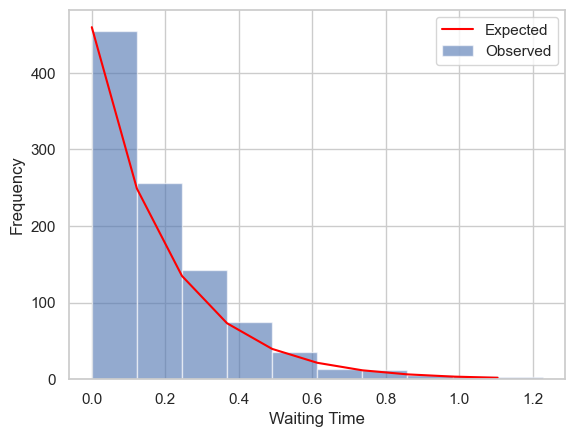

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
from typing import List

# 卡方检验函数
def chi_square_test(waiting_times, expected_distribution, num_bins=10):
    # 将乘客等待时间数据分为多个区间（bins）
    max_waiting_time = max(waiting_times)
    bin_edges = np.linspace(0, max_waiting_time, num_bins + 1)
    observed_freq, _ = np.histogram(waiting_times, bins=bin_edges)
    
    # 计算每个区间的期望频率
    total_riders = len(waiting_times)
    expected_freq = []
    for i in range(num_bins):
        lower_bound = bin_edges[i]
        upper_bound = bin_edges[i + 1]
        probability = expected_distribution(upper_bound) - expected_distribution(lower_bound)
        expected_freq.append(probability * total_riders)
    
    # 确保期望频率的总和和观测频率的总和一致
    observed_sum = np.sum(observed_freq)
    expected_sum = np.sum(expected_freq)
    
    # 如果总和不一致，进行微调
    if observed_sum != expected_sum:
        adjustment_factor = observed_sum / expected_sum
        expected_freq = [freq * adjustment_factor for freq in expected_freq]
    
    # 使用卡方检验比较观测频率和期望频率
    chi2_stat, p_value = stats.chisquare(observed_freq, expected_freq, ddof=0)
    
    print(f"Chi-square statistic: {chi2_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    
    # 绘制观察频率和期望频率的图形
    plt.bar(bin_edges[:-1], observed_freq, width=np.diff(bin_edges), alpha=0.6, label='Observed', align='edge')
    plt.plot(bin_edges[:-1], expected_freq, label='Expected', color='red')
    plt.xlabel('Waiting Time')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# 理论指数分布的累积分布函数 (CDF)
def expected_distribution(x: float) -> float:
    return 1 - np.exp(-5 * x)  # 理论的等待时间分布（指数分布，lambda = 5）

# 模拟乘客等待时间函数
def simulate_riders_waiting_times(sim: 'Simulation', num_riders: int = 1000) -> List[float]:
    """模拟乘客等待时间"""
    waiting_times = []
    for _ in range(num_riders):
        # 现在传递 request_time 参数
        rider = Rider(
            rider_id=len(sim.riders) + 1,
            pickup_location=(random.uniform(0, 20), random.uniform(0, 20)),
            dropoff_location=(random.uniform(0, 20), random.uniform(0, 20)),
        )
        rider.request_time = sim.current_time  # 设置乘客的请求时间
        sim.riders.append(rider)
        sim.waiting_riders.append(rider)
        waiting_times.append(rider.patience)  # 乘客的耐心时间
    return waiting_times

# 在模拟结束后调用统计假设检验
if __name__ == "__main__":
    # 在此处运行你的模拟或其他测试函数
    test_distributions()  # 分布验证
    sim.run()

    # 获取模拟乘客的等待时间
    waiting_times = simulate_riders_waiting_times(sim, num_riders=1000)
    
    # 进行卡方检验
    chi_square_test(waiting_times, expected_distribution)


模型优化1：提高司机的数量将间隔数从3调成5
当间隔数为3时：
<br>Abandoned Riders: 232
<br>Avg Waiting Time: 0.35h
<br>Total Driver Earnings: £8948.82
<br>Median Hourly Earnings: £20.21
<br>Driver Earnings Std Dev: £82.60
<br>Gini Coefficient for Driver Earnings: 0.3024
<br>Average Driver Earnings per Hour: £127.18
<br>Average Driver Earnings per Hour (based on individual hourly earnings): £21.78
<br>Average Driver Rest Time: 4.09 hours
<br>Median Wait Time: 0.50h
<br>95th Percentile Wait Time: 1.03h
<br>Completed Riders: 472
<br>Abandoned Riders: 232
<br>Order Completion Rate: 67.05%
<br>Vehicle Utilization: 37.26%
<br>Average Trip Duration: 0.53 hours

当间隔数为5时：
<br>bandoned Riders: 111
<br>Avg Waiting Time: 0.31h
<br>Total Driver Earnings: £10384.44
<br>Median Hourly Earnings: £30.19
<br>Driver Earnings Std Dev: £35.62
<br>Gini Coefficient for Driver Earnings: 0.1557
<br>Average Driver Earnings per Hour: £166.87
<br>Average Driver Earnings per Hour (based on individual hourly earnings): £57.53
<br>Average Driver Rest Time: 4.89 hours
<br>Median Wait Time: 0.29h
<br>95th Percentile Wait Time: 0.92h
<br>Completed Riders: 556
<br>Abandoned Riders: 111
<br>Order Completion Rate: 83.36%
<br>Vehicle Utilization: 27.22%
<br>Average Trip Duration: 0.50 hours

<br>1.放弃乘车的乘客个数
<br>间隔3小时时: 232个
<br>间隔5小时时: 111个
<br>分析: 随着司机到达间隔从3小时增加到5小时，被放弃的骑行次数明显减少（减少了121个骑行），这表明延长司机到达间隔有助于减少放弃率，可能是因为司机能更快满足需求，提高了乘客的等待满意度。
<br>2. 平均等待时间：
<br>间隔3小时时: 0.35小时
<br>间隔5小时时: 0.31小时
<br>分析: 平均等待时间略微减少，虽然这个差异不大，但表明随着司机到达间隔增加，乘客可能会等待较短的时间。
<br>3. 司机总收入：
<br>间隔3小时时: £8948.82
<br>间隔5小时时: £10384.44
<br>分析: 总收入增加了，反映出虽然骑行数量较少（完成的骑行从472减少到556），但平均每个骑行的收入有所增加，可能是由于更高效的订单匹配和更高的订单完成率。
<br>4. 司机的小时收入（中位数和平均数）:
<br>间隔3小时时:
<br>中位数小时收入: £20.21
<br>平均小时收入: £127.18
<br>间隔5小时时:
<br>中位数小时收入: £30.19
<br>平均小时收入: £166.87
<br>分析: 司机的收入水平提升了，尤其是平均小时收入的显著增长，可能是由于每小时的订单完成效率提升，司机在单位时间内赚得更多。
<br>5. 司机收入标准差：
<br>间隔3小时时: £82.60
<br>间隔5小时时: £35.62
<br>分析: 收入的波动性大大降低，标准差从82.60减少到35.62，说明收入分布更加稳定，收入差异性减少。
<br>6. 基尼系数：
<br>间隔3小时时: 0.3024
<br>间隔5小时时: 0.1557
<br>分析: 基尼系数显著下降，意味着司机之间收入的分配更加公平，收入差距较小。
<br>7. 完单率：
<br>间隔3小时时: 67.05%
<br>间隔5小时时: 83.36%
<br>分析: 完单率提高了，表明通过增加司机到达间隔，平台能够更有效地完成骑行订单，这对系统的整体效率是正面的提升。
<br>8. 车辆利用率：
<br>间隔3小时时: 37.26%
<br>间隔5小时时: 27.22%
<br>分析: 车辆利用率有所下降，可能是因为司机之间的间隔增大，导致整体的供需匹配不如之前紧凑。这可能导致部分司机处于空闲状态，但这也表明服务质量的提升。
<br>9. 平均行程时长：
<br>间隔3小时时: 0.53小时
<br>间隔5小时时: 0.50小时
<br>分析: 平均行程时长略微减少，可能是由于司机的调度更加高效，行程更集中，减少了空驶和等待时间。

<br>优化效果: 将司机到达间隔从3小时增加到5小时，显著提高了完单率（从67.05%到83.36%）和司机收入（特别是平均每小时收入的增加），同时减少了乘客放弃打车的次数。总体来看，这个变化对整体系统是有优化效果的。
<br>影响:
收入分布更均衡（基尼系数减少），司机的收入水平更稳定。
虽然车辆利用率略有下降，但由于更高的完单率和更少的放弃骑行，系统的整体效益得到了提升。
平均等待时间略有改善，乘客的等待体验有所优化。
<br>建议:
如果想进一步提升车辆利用率，可以考虑优化司机调度机制，寻找一种平衡司机到达间隔和车辆利用率的策略，避免过度空闲的情况。
继续保持或进一步提升司机收入的平衡性，确保高收入同时不损害平台的运作效率。
整体来看，司机到达间隔延长确实带来了一些正面影响，但也需要根据业务需求和优化目标，进一步平衡效率和服务质量

模型优化2：将司机排序依据从接客距离改为接客距离+行程距离总和，确保选择处理总时间（接客+行程）最短的司机，提高司机周转率。
<br>这个是上面最新的模拟系统模型改的

In [121]:
from typing import Callable, List, Dict, Any, Tuple, TYPE_CHECKING
from bisect import bisect_right
import random
import math

print('boxcar_simulation.py loaded successfully')

# 定义司机
class Driver:
    def __init__(self, driver_id: int):
        self.id = driver_id  
        self.location = (random.uniform(0, 20), random.uniform(0, 20))  # 初始位置随机
        self.availability_time = random.uniform(5, 8)  # 司机在线时间均匀分布(5-8小时)
        self.status = 'available'  
        self.earnings = 0.0 
        self.total_miles = 0.0 #司机的总行驶距离
        self.scheduled_offline = False  # 离线标记
        self.total_active_time = 0.0  # 记录司机的工作时间（接客+行程）
# 定义乘客
class Rider:
    def __init__(self, rider_id: int, pickup_location: tuple, dropoff_location: tuple):
        self.id = rider_id
        self.pickup_location = pickup_location #接送地点
        self.dropoff_location = dropoff_location #下车地点
        self.patience = random.expovariate(5)  # 耐心等待期限-指数分布(5/hour)
        self.status = 'waiting'
        self.request_time = 0.0 #顾客发起请求的时间
        self.pickup_time = 0.0  #司机到达并接载乘客的时间
        
# 记录每次乘车的具体信息
class TripRecord:
    def __init__(self, rider_id: int, driver_id: int, pickup_distance: float, trip_distance: float):
        self.rider_id = rider_id
        self.driver_id = driver_id
        self.pickup_distance = pickup_distance
        self.trip_distance = trip_distance
        self.waiting_time = 0.0
        self.payment = 3 + 2 * trip_distance  # 记录支付金额(=driver earnings)
        self.driver_cost = 0.2 * (trip_distance + pickup_distance)   #车的燃油成本
        self.trip_duration = 0.0  # 司机接到乘客到司机完成行程并送乘客到目的地的这段时间
        self.completed_riders = 0  # 完成的乘客数
        
    
# Simulation
class Simulation:
    def __init__(self, distributions: Any = None):
        self.simulation_length = 24 * 1 # 模拟n天(hour)
        self.current_time = 0.0
        self.riders: List[Rider] = [] #存储所有乘客对象
        self.drivers: List[Driver] = [] #存储所有司机对象
        self.waiting_riders: List[Rider] = [] #存储当前还在等待的乘客对象
        self.active_trips: Dict[int, TripRecord] = {}  #存储正在进行的行程
        self.abandoned_riders = 0  
        self.total_waiting_time = 0.0 #所有乘客总等待时间,计算乘客的平均等待时间
        self.total_driver_earnings = 0.0  #所有司机的总收入,计算司机的平均收入
        self.trip_records: List[TripRecord] = []  #用于存储所有完成的行程记录
        self.event_calendar: List[Dict[str, Any]] = [] #事件日历，存储模拟过程中的所有事件。每个事件是一个字典，包含了事件的时间、类型和相关数据。事件按照时间顺序排序。
        self.distributions: Dict[str, Callable[[], float]] = {} #存储分布函数
        self.event_handlers: Dict[str, Callable[[Simulation, Any], None]] = {} #存储了每个事件类型对应的处理函数
        self.driver_earnings: Dict[int, float] = {}  # 记录司机收入
        self.driver_trips: Dict[int, int] = {}       # 记录每个司机完成的行程次数(工作量)
        self.completed_riders = 0  # 确保初始化了这个属性
# 建立分布函数---模拟乘客和司机的到达事件
        if distributions:
            self.register_distribution('rider_arrival', distributions.rider_interarrival)  #乘客到达间隔的分布函数
            self.register_distribution('driver_arrival', distributions.driver_interarrival) #司机到达间隔的分布函数
        
        #添加新事件
        self.add_event(self.current_time + self.distributions['rider_arrival'](), 'rider_arrival', None)    #当前时间+当前乘客到达间隔随机时间=乘客何时到达模拟系统(request_time)
        self.add_event(self.current_time + self.distributions['driver_arrival'](), 'driver_available', None) #当前时间+当前司机到达间隔随机时间=司机何时到达模拟系统,同时会在event_calendar添加司机available事件)
        self.add_event(self.simulation_length, 'termination', None)  #模拟总时长

# 确保每个事件按其发生的时间顺序被正确处理
    def add_event(self, event_time: float, event_type: str, event_data: Any = None) -> None: #
        event = {'time': event_time, 'type': event_type, 'data': event_data}
        index = bisect_right([e['time'] for e in self.event_calendar], event_time)
        self.event_calendar.insert(index, event)

#注册分布函数到simulation中    
    def register_distribution(self, name: str, handler: Callable[[], float]) -> None:
        self.distributions[name] = handler

#注册事件处理函数到simulation中
    def register_event_handler(self, event_type: str, handler: Callable[['Simulation', Any], None]) -> None:
        self.event_handlers[event_type] = handler

#推进模拟时间并处理下一个事件
    def progress_time(self) -> None:
        if not self.event_calendar:
            print("No more events to process.") #检查event_calendar是否为空
            return
        
        next_event = self.event_calendar.pop(0)  #更新下一次事件
        self.current_time = next_event['time']   #更新当前模拟事件
        event_type = next_event['type']          #根据事件类型找对应的处理函数
        event_data = next_event['data']          #传入数据处理
        print(f"\n--- Processing {event_type} at {self.current_time:.2f}h ---")    
        
        if event_type in self.event_handlers:   #调用与事件相应的处理函数
            self.event_handlers[event_type](self, event_data)
        else:
            print(f"Warning: No handler for {event_type}")

# 计算基尼系数
    def calculate_gini_coefficient(self, earnings: List[float]) -> float:
        """计算基尼系数来衡量收入分配的公平性"""
        n = len(earnings)
        if n == 0:
            return 0.0  # 如果没有司机，基尼系数为0
        
        # 计算所有收入对之间的绝对差值的总和
        total_diff = sum(abs(x - y) for x in earnings for y in earnings)
        
        # 计算平均收入
        mean_earnings = sum(earnings) / n
        
        # 计算基尼系数
        gini = total_diff / (2 * n**2 * mean_earnings)
        return gini
    
# 运行模拟过程
    def run(self) -> None:
        while self.event_calendar:
            self.progress_time()  #运用progress_time处理下一个事件
            if self.current_time >= self.simulation_length:
                break
    
        print("\n=== Simulation Results ===")
        print(f"Abandoned Riders: {self.abandoned_riders}") #放弃乘车的乘客数量
        print(f"Completed Riders: {self.completed_riders}")
        print(f"Avg Waiting Time: {self.total_waiting_time / len(self.riders) if self.riders else 0:.2f}h")   #乘客的平均等待时间
        print(f"Total Driver Earnings: £{self.total_driver_earnings:.2f}")  #所有司机的总收入
    
       
    #评估drivers的满意度:
        # 计算司机时薪的中位数
        driver_hourly_earnings = [ self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]
        if driver_hourly_earnings:
            median_hourly_earnings = np.median(driver_hourly_earnings)
            print(f"Median Hourly Earnings: £{median_hourly_earnings:.2f}")
        else:
            print("No valid active time for calculating median hourly earnings.")

        #公平性指标1: 标准差衡量司机每小时收入
        earnings = list(self.driver_earnings.values()) #获取所有司机收入
        if len(earnings) > 1:
            mean = sum(earnings) / len(earnings)
            variance = sum((x - mean)**2 for x in earnings) / len(earnings)
            std_dev = math.sqrt(variance)
            print(f"Driver Earnings Std Dev: £{std_dev:.2f}")

        #公平性指标2: 计算基尼系数
        gini = self.calculate_gini_coefficient(earnings)
        print(f"Gini Coefficient for Driver Earnings: {gini:.4f}")
        
        # 计算司机的平均时薪--评估司机的工作负荷
        total_driver_hours = sum(driver.total_active_time for driver in sim.drivers)
        if total_driver_hours > 0:
           avg_hourly_earnings = self.total_driver_earnings / total_driver_hours
           print(f"Average Driver Earnings per Hour: £{avg_hourly_earnings:.2f}")
        else:
           print("No active hours to calculate earnings.")
        
        # 计算每个司机的时薪，并计算所有司机时薪的平均值
        driver_hourly_earnings = [self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]

        if driver_hourly_earnings:
          avg_hourly_earnings_2 = sum(driver_hourly_earnings) / len(driver_hourly_earnings)
          print(f"Average Driver Earnings per Hour (based on individual hourly earnings): £{avg_hourly_earnings_2:.2f}")
        else:
          print("No active hours to calculate earnings.")

           
        #计算平均休息时间
        if self.drivers: #检查是否有司机,避免在没有司机情况下计算平均休息时间
            avg_rest_time = sum(d.availability_time - d.total_active_time for d in self.drivers) / len(self.drivers) #在线时间-实际工作时间(接到乘客)
            print(f"Average Driver Rest Time: {avg_rest_time:.2f} hours")
    
    #评估Riders的满意度
        #记录乘客的等待时间分布
        waiting_times = [r.pickup_time - r.request_time for r in sim.riders if r.status == "in_progress"] #确保只计算那些正在进行行程中的乘客
        if waiting_times: #检查等待时间列表是否为空,如果非空继续执行
            median_wait = sorted(waiting_times)[len(waiting_times) // 2]
            percentile_95_wait = sorted(waiting_times)[int(len(waiting_times) * 0.95)] #所有乘客中最迟的5%的乘客的等待时间,这个值表示大约95%的乘客的等待时间小于或等于这个时间            
            print(f"Median Wait Time: {median_wait:.2f}h")
            print(f"95th Percentile Wait Time: {percentile_95_wait:.2f}h")
        
        # 订单完成率(完成和取消)---前面已知放弃乘车的乘客数量
        total_riders = len(self.riders)
        completed_riders = total_riders - self.abandoned_riders
        completion_rate = completed_riders / total_riders if total_riders > 0 else 0
        print(f"Completed Riders: {completed_riders}")
        print(f"Abandoned Riders: {self.abandoned_riders}")
        print(f"Order Completion Rate: {completion_rate:.2%}")

    #运营效率的评估
        #指标1:车辆利用率--
        if self.drivers:
            total_active_time = sum(driver.total_active_time for driver in self.drivers)
            total_availability_time = sum(driver.availability_time for driver in self.drivers)
            vehicle_utilization = total_active_time / total_availability_time if total_availability_time > 0 else 0
            print(f"Vehicle Utilization: {vehicle_utilization:.2%}")
        
        #指标2: 统计所有乘客平均行程时间--评估乘客的整体出行效率和系统调度的效果
        if self.trip_records:
            total_trip_duration = sum(record.trip_duration for record in self.trip_records)
            avg_trip_duration = total_trip_duration / len(self.trip_records)
            print(f"Average Trip Duration: {avg_trip_duration:.2f} hours")
        else:
            print("No trip records available to calculate average trip duration.")

# 计算欧几里得距离
def euclidean_distance(loc1: tuple, loc2: tuple) -> float:
    """计算两点之间的欧几里得距离"""
    return math.sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

#模拟处理司机到达乘客上车点事件-接乘客
def handle_pickup_complete(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    """处理司机到达乘客上车点事件"""
    driver, rider, pickup_time = event_data # 从event_data将driver,rider和pickup_time属性取出
    rider.pickup_time = sim.current_time # 乘客被接走的时间点
    rider.status = "in_progress"

    # 计算行程距离和时间
    trip_distance = euclidean_distance(rider.pickup_location, rider.dropoff_location) #利用欧几里得算行程距离
    mu_trip = trip_distance / 20  # 司机开车平均速度20mph----生成理想的每次行程时间数据  
    trip_time = random.uniform(0.8 * mu_trip, 1.2 * mu_trip)  # 由于时间的随机性----模拟生成现实中每次行程的时间数据

    # 安排行程结束事件
    sim.add_event(sim.current_time + trip_time, "trip_end", (driver, rider, trip_distance,pickup_time)) #行程结束后，处理行程的结算（计算司机的收入、更新司机乘客的状态等）

#模拟行程结束后事件-更新最新数据
def handle_trip_end(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    """处理行程结束事件"""
    driver, rider, trip_distance, pickup_time = event_data
    # 更新司机状态和位置
    driver.status = "available"
    driver.location = rider.dropoff_location  # 司机移动到目的地

    # 添加完成状态更新
    rider.status = 'completed'
    sim.completed_riders += 1
    sim.total_waiting_time += (rider.pickup_time - rider.request_time)

    # 计算收入和成本
    pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 计算接客距离
    payment = 3 + 2 * trip_distance  # £3初始费用 + £2/英里
    driver_cost = 0.2 * (trip_distance+ pickup_distance)  # £0.2/英里油费
    driver.earnings += (payment - driver_cost) #司机的净收入
    sim.total_driver_earnings += (payment - driver_cost) #更新整个模拟系统中总司机的净收入
    # 更新司机收入和服务次数
    sim.driver_earnings[driver.id] = driver.earnings #将当前司机的收入更新到driver.earnings中
    sim.driver_trips[driver.id] = sim.driver_trips.get(driver.id, 0) + 1 #更新司机的服务次数(司机已完成的行程数量)

    # 记录等待时间--累加记录系统用于后面计算平均等待时间
    sim.total_waiting_time += (rider.pickup_time - rider.request_time)
    # 生成行程记录
    pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 接客距离
    trip_record = TripRecord(rider.id, driver.id, pickup_distance, trip_distance) #创建新的行程记录对象
    trip_record.trip_duration = sim.current_time - rider.pickup_time  #记录行程时长(接到乘客到行程结束)
    sim.trip_records.append(trip_record) #保留行程所有数据

    # 司机重新可用后尝试匹配等待中的乘客
    if sim.waiting_riders:
        next_rider = sim.waiting_riders[0]  #等待中的第一个乘客
        match_rider_to_driver(sim, next_rider)  #调用匹配函数将司机与该乘客匹配，开始新的行程

    # 检查司机是否需要离线
    if driver.scheduled_offline:
        driver.scheduled_offline = False #如果司机离线
        sim.add_event(sim.current_time, "driver_offline", driver) #添加一个司机离线事件,表示已有一名司机下线

    # 计算行程时间
    trip_time = random.uniform(0.8 * (trip_distance / 20), 1.2 * (trip_distance / 20))
    driver.total_active_time += pickup_time + trip_time  # 更新司机的活跃时间(记录司机活跃时间)--包括接乘客和行使的时间,方便后面计算车辆利用率的指标以及平均休息时间

#司机与乘客的匹配
def match_rider_to_driver(sim: Simulation, rider: Rider):
    """匹配最近的可用司机"""
    available_drivers = [d for d in sim.drivers if d.status == "available"] #从drivers list里面选出当前状态为available的driver
    if not available_drivers:
        print(f"乘客{rider.id} No driver available. Keep waiting...")
        return
    
    # 计算所有可用司机到乘客的接客距离，按升序排序,将离乘客距离最近的司机匹配上
    # 计算所有可用司机到乘客的接客距离，按升序排序,将离乘客距离最近的司机匹配上
    trip_distance = euclidean_distance(rider.pickup_location, rider.dropoff_location)
    available_drivers.sort(
        key=lambda d: euclidean_distance(d.location, rider.pickup_location) + trip_distance
    )
    # 选择最近的司机（排序后第一个元素）
    closest_driver = available_drivers[0]
    
    # 更新司机和乘客状态
    closest_driver.status = "occupied"
    if rider in sim.waiting_riders:
        sim.waiting_riders.remove(rider) #将已匹配的乘客移除'等待中的乘客列表'外
    rider.status = "matched"
    
    # 计算接客时间和距离
    pickup_distance = euclidean_distance(closest_driver.location, rider.pickup_location)
    mu_pickup = pickup_distance / 20  # 平均速度20mph
    pickup_time = random.uniform(0.8 * mu_pickup, 1.2 * mu_pickup)  # 时间随机性
    
    # 安排接客完成事件--存入event_calendar(按时间顺序)
    sim.add_event(
        sim.current_time + pickup_time, 
        "pickup_complete", 
        (closest_driver, rider, pickup_time)
    )

# 乘客到达事件---乘客的到达和等待
def handle_rider_arrival(sim: Simulation, event_data: Any) -> None:
    rider_id = len(sim.riders) + 1 #为每个新乘客分配id
    origin = (random.uniform(0, 20), random.uniform(0, 20)) #随机生成请求乘车的地点
    destination = (random.uniform(0, 20), random.uniform(0, 20))
    rider = Rider(rider_id, origin, destination)   #创建新的rider对象
    rider.request_time = sim.current_time 
    sim.riders.append(rider)  #加入所有乘客列表
    sim.waiting_riders.append(rider) #加入等待列表
    # 安排乘客超时事件
    sim.add_event(sim.current_time + rider.patience, "rider_timeout", rider)  
    sim.add_event(sim.current_time + sim.distributions["rider_arrival"](), "rider_arrival") #安排下一次乘客到达事件
    # 立即尝试匹配
    match_rider_to_driver(sim, rider)

#乘客等待超时事件--如果在未来的时间点触发了安排下一位乘客到达,此函数会检测到上一个rider还处于waiting的状态,超时了即放弃
def handle_rider_timeout(sim: Simulation, rider: Rider):
    if rider.status == 'waiting':
        rider.status = 'abandoned'
        sim.abandoned_riders += 1 #放弃乘客数量+1
        sim.waiting_riders.remove(rider) #将放弃等待的乘客从等待列表中移除

#司机可用事件
def handle_driver_available(sim: Simulation, event_data: Any) -> None:
    driver_id = len(sim.drivers) + 1
    driver = Driver(driver_id) #创建新的driver对象-new driver
    sim.drivers.append(driver) #将创建的司机加入新列表,表示该司机加入了系统并准备接受任务
    # 司机离线时间处理
    planned_offline_time = sim.current_time + driver.availability_time #司机上线后的工作时间
    sim.add_event(planned_offline_time, "driver_offline", driver) # 添加一个离线事件,标明司机下线
    sim.add_event(sim.current_time + sim.distributions["driver_arrival"](), "driver_available") #安排下一个司机到达
    # 司机上线后立即尝试匹配
    if sim.waiting_riders: #是否有等待中的乘客
        next_rider = sim.waiting_riders[0] #当前最早等待的乘客
        match_rider_to_driver(sim, next_rider)

def handle_driver_offline(sim: Simulation, event_data: Driver) -> None:
    """处理司机离线事件（状态检查）"""
    if event_data.status == "occupied":
        event_data.scheduled_offline = True  # 标记延迟离线,该司机计划在当前行程结束后离线
        print(f"司机{event_data.id}正在服务中，将在行程结束后离线")
    else:
        event_data.status = "offline"
        sim.drivers.remove(event_data)
        print(f"司机 {event_data.id} 已立即下线")

class Distributions:
    def __init__(self):
        pass  # 存储模拟对象（如果需要的话）
    
    def rider_interarrival(self) -> float:
        """生成乘客到达间隔的时间（基于指数分布）"""
        rate = 30  # λ (rate parameter for passenger arrival)
        interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
        return interarrival_time
    
    def driver_interarrival(self) -> float:
        """生成司机到达间隔的时间（基于指数分布）"""
        rate = 3  # λ (rate parameter for driver arrival)
        interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
        return interarrival_time
    
# 注册事件处理器-作用:模拟系统会将每个事件与它对应的事件处理函数绑定。当事件发生时,系统会自动调用相应的处理函数，更新模拟状态
sim = Simulation(distributions=Distributions())
sim.register_event_handler("rider_arrival", handle_rider_arrival) #当乘客到达时，调用 handle_rider_arrival 处理函数
sim.register_event_handler("driver_available", handle_driver_available) #当司机变为可用时，调用 handle_driver_available 处理函数
sim.register_event_handler("trip_end", handle_trip_end) #当行程结束时，调用 handle_trip_end 处理函数
sim.register_event_handler("rider_timeout", handle_rider_timeout) #当乘客等待超时时，调用 handle_rider_timeout 处理函数
sim.register_event_handler("driver_offline", handle_driver_offline) #当司机下线时，调用 handle_driver_offline 处理函数
sim.register_event_handler("termination", lambda sim, event_data: print("Simulation terminated.")) #模拟结束时，输出 "Simulation terminated
sim.register_event_handler("pickup_complete", handle_pickup_complete) #当司机接到乘客时，调用 handle_pickup_complete 处理函数


# 验证分布的测试函数--确保模拟的随机事件符合预期的统计规律
def test_distributions():
    # 验证乘客到达间隔
    samples = [random.expovariate(30) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"\n[分布验证] 乘客到达间隔均值: {avg:.4f}h (理论值: {1/30:.4f}h)")

    # 验证司机在线时间
    samples = [random.uniform(5,8) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"[分布验证] 司机在线时间均值: {avg:.2f}h (理论值: 6.50h)")

# 主程序 
if __name__ == "__main__":
    test_distributions()  # 分布验证
    sim.run()

boxcar_simulation.py loaded successfully

[分布验证] 乘客到达间隔均值: 0.0331h (理论值: 0.0333h)
[分布验证] 司机在线时间均值: 6.51h (理论值: 6.50h)

--- Processing rider_arrival at 0.03h ---
乘客1 No driver available. Keep waiting...

--- Processing rider_arrival at 0.09h ---
乘客2 No driver available. Keep waiting...

--- Processing rider_arrival at 0.09h ---
乘客3 No driver available. Keep waiting...

--- Processing rider_arrival at 0.15h ---
乘客4 No driver available. Keep waiting...

--- Processing rider_arrival at 0.16h ---
乘客5 No driver available. Keep waiting...

--- Processing rider_arrival at 0.16h ---
乘客6 No driver available. Keep waiting...

--- Processing rider_arrival at 0.16h ---
乘客7 No driver available. Keep waiting...

--- Processing rider_arrival at 0.18h ---
乘客8 No driver available. Keep waiting...

--- Processing rider_timeout at 0.22h ---

--- Processing rider_timeout at 0.23h ---

--- Processing rider_arrival at 0.24h ---
乘客9 No driver available. Keep waiting...

--- Processing rider_timeout at 0.24h -

这也是模型2，但是是旧的模拟系统的模型改的，跑出来的结果会有差距

In [ ]:
from typing import Callable, List, Dict, Any, Tuple, TYPE_CHECKING
from bisect import bisect_right
import random
import math

print('boxcar_simulation.py loaded successfully')

# 定义司机
class Driver:
    def __init__(self, driver_id: int):
        self.id = driver_id  
        self.location = (random.uniform(0, 20), random.uniform(0, 20))  # 初始位置随机
        self.availability_time = random.uniform(5, 8)  # 司机在线时间均匀分布(5-8小时)
        self.status = 'available'  
        self.earnings = 0.0 
        self.total_miles = 0.0 #司机的总行驶距离
        self.scheduled_offline = False  # 离线标记
        self.total_active_time = 0.0  # 记录司机的工作时间（接客+行程）
# 定义乘客
class Rider:
    def __init__(self, rider_id: int, pickup_location: tuple, dropoff_location: tuple):
        self.id = rider_id
        self.pickup_location = pickup_location #接送地点
        self.dropoff_location = dropoff_location #下车地点
        self.patience = random.expovariate(5)  # 耐心等待期限-指数分布(5/hour)
        self.status = 'waiting'
        self.request_time = 0.0 #顾客发起请求的时间
        self.pickup_time = 0.0  #司机到达并接载乘客的时间
# 记录每次乘车的具体信息
class TripRecord:
    def __init__(self, rider_id: int, driver_id: int, pickup_distance: float, trip_distance: float):
        self.rider_id = rider_id
        self.driver_id = driver_id
        self.pickup_distance = pickup_distance
        self.trip_distance = trip_distance
        self.waiting_time = 0.0
        self.payment = 3 + 2 * trip_distance  # 记录支付金额(=driver earnings)
        self.driver_cost = 0.2 * (trip_distance + pickup_distance)   #车的燃油成本
        self.trip_duration = 0.0  # 司机接到乘客到司机完成行程并送乘客到目的地的这段时间

# Simulation
class Simulation:
    def __init__(self, distributions: Any = None):
        self.simulation_length = 24 * 1 # 模拟n天(hour)
        self.current_time = 0.0
        self.riders: List[Rider] = [] #存储所有乘客对象
        self.drivers: List[Driver] = [] #存储所有司机对象
        self.waiting_riders: List[Rider] = [] #存储当前还在等待的乘客对象
        self.active_trips: Dict[int, TripRecord] = {}  #存储正在进行的行程
        self.abandoned_riders = 0  
        self.total_waiting_time = 0.0 #所有乘客总等待时间,计算乘客的平均等待时间
        self.total_driver_earnings = 0.0  #所有司机的总收入,计算司机的平均收入
        self.trip_records: List[TripRecord] = []  #用于存储所有完成的行程记录
        self.event_calendar: List[Dict[str, Any]] = [] #事件日历，存储模拟过程中的所有事件。每个事件是一个字典，包含了事件的时间、类型和相关数据。事件按照时间顺序排序。
        self.distributions: Dict[str, Callable[[], float]] = {} #存储分布函数
        self.event_handlers: Dict[str, Callable[[Simulation, Any], None]] = {} #存储了每个事件类型对应的处理函数
        self.driver_earnings: Dict[int, float] = {}  # 记录司机收入
        self.driver_trips: Dict[int, int] = {}       # 记录每个司机完成的行程次数(工作量)

# 建立分布函数---模拟乘客和司机的到达事件
        if distributions:
            self.register_distribution('rider_arrival', distributions.rider_interarrival)  #乘客到达间隔的分布函数
            self.register_distribution('driver_arrival', distributions.driver_interarrival) #司机到达间隔的分布函数
        
        #添加新事件
        self.add_event(self.current_time + self.distributions['rider_arrival'](), 'rider_arrival', None)    #当前时间+当前乘客到达间隔随机时间=乘客何时到达模拟系统(request_time)
        self.add_event(self.current_time + self.distributions['driver_arrival'](), 'driver_available', None) #当前时间+当前司机到达间隔随机时间=司机何时到达模拟系统,同时会在event_calendar添加司机available事件)
        self.add_event(self.simulation_length, 'termination', None)  #模拟总时长

# 确保每个事件按其发生的时间顺序被正确处理
    def add_event(self, event_time: float, event_type: str, event_data: Any = None) -> None: #
        event = {'time': event_time, 'type': event_type, 'data': event_data}
        index = bisect_right([e['time'] for e in self.event_calendar], event_time)
        self.event_calendar.insert(index, event)

#注册分布函数到simulation中    
    def register_distribution(self, name: str, handler: Callable[[], float]) -> None:
        self.distributions[name] = handler

#注册事件处理函数到simulation中
    def register_event_handler(self, event_type: str, handler: Callable[['Simulation', Any], None]) -> None:
        self.event_handlers[event_type] = handler

#推进模拟时间并处理下一个事件
    def progress_time(self) -> None:
        if not self.event_calendar:
            print("No more events to process.") #检查event_calendar是否为空
            return
        
        next_event = self.event_calendar.pop(0)  #更新下一次事件
        self.current_time = next_event['time']   #更新当前模拟事件
        event_type = next_event['type']          #根据事件类型找对应的处理函数
        event_data = next_event['data']          #传入数据处理
        print(f"\n--- Processing {event_type} at {self.current_time:.2f}h ---")    
        
        if event_type in self.event_handlers:   #调用与事件相应的处理函数
            self.event_handlers[event_type](self, event_data)
        else:
            print(f"Warning: No handler for {event_type}")

# 计算基尼系数
    def calculate_gini_coefficient(self, earnings: List[float]) -> float:
        """计算基尼系数来衡量收入分配的公平性"""
        n = len(earnings)
        if n == 0:
            return 0.0  # 如果没有司机，基尼系数为0
        
        # 计算所有收入对之间的绝对差值的总和
        total_diff = sum(abs(x - y) for x in earnings for y in earnings)
        
        # 计算平均收入
        mean_earnings = sum(earnings) / n
        
        # 计算基尼系数
        gini = total_diff / (2 * n**2 * mean_earnings)
        return gini
    
# 运行模拟过程
    def run(self) -> None:
        while self.event_calendar:
            self.progress_time()  #运用progress_time处理下一个事件
            if self.current_time >= self.simulation_length:
                break
        print("\n=== Simulation Results ===")
        print(f"Abandoned Riders: {self.abandoned_riders}") #放弃乘车的乘客数量
        print(f"Avg Waiting Time: {self.total_waiting_time / len(self.riders) if self.riders else 0:.2f}h")   #乘客的平均等待时间
        print(f"Total Driver Earnings: £{self.total_driver_earnings:.2f}")  #所有司机的总收入
    
       

    #评估drivers的满意度:
        # 计算司机时薪的中位数
        driver_hourly_earnings = [ self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]
        if driver_hourly_earnings:
            median_hourly_earnings = np.median(driver_hourly_earnings)
            print(f"Median Hourly Earnings: £{median_hourly_earnings:.2f}")
        else:
            print("No valid active time for calculating median hourly earnings.")

        #公平性指标1: 标准差衡量司机每小时收入
        earnings = list(self.driver_earnings.values()) #获取所有司机收入
        if len(earnings) > 1:
            mean = sum(earnings) / len(earnings)
            variance = sum((x - mean)**2 for x in earnings) / len(earnings)
            std_dev = math.sqrt(variance)
            print(f"Driver Earnings Std Dev: £{std_dev:.2f}")

        #公平性指标2: 计算基尼系数
        gini = self.calculate_gini_coefficient(earnings)
        print(f"Gini Coefficient for Driver Earnings: {gini:.4f}")
        
        # 计算司机的平均时薪--评估司机的工作负荷
        total_driver_hours = sum(driver.total_active_time for driver in sim.drivers)
        if total_driver_hours > 0:
           avg_hourly_earnings = self.total_driver_earnings / total_driver_hours
           print(f"Average Driver Earnings per Hour: £{avg_hourly_earnings:.2f}")
        else:
           print("No active hours to calculate earnings.")
        
        # 计算每个司机的时薪，并计算所有司机时薪的平均值
        driver_hourly_earnings = [self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]

        if driver_hourly_earnings:
          avg_hourly_earnings_2 = sum(driver_hourly_earnings) / len(driver_hourly_earnings)
          print(f"Average Driver Earnings per Hour (based on individual hourly earnings): £{avg_hourly_earnings_2:.2f}")
        else:
          print("No active hours to calculate earnings.")

           
        #计算平均休息时间
        if self.drivers: #检查是否有司机,避免在没有司机情况下计算平均休息时间
            avg_rest_time = sum(d.availability_time - d.total_active_time for d in self.drivers) / len(self.drivers) #在线时间-实际工作时间(接到乘客)
            print(f"Average Driver Rest Time: {avg_rest_time:.2f} hours")
    
    #评估Riders的满意度
        #记录乘客的等待时间分布
        waiting_times = [r.pickup_time - r.request_time for r in sim.riders if r.status == "in_progress"] #确保只计算那些正在进行行程中的乘客
        if waiting_times: #检查等待时间列表是否为空,如果非空继续执行
            median_wait = sorted(waiting_times)[len(waiting_times) // 2]
            percentile_95_wait = sorted(waiting_times)[int(len(waiting_times) * 0.95)] #所有乘客中最迟的5%的乘客的等待时间,这个值表示大约95%的乘客的等待时间小于或等于这个时间            
            print(f"Median Wait Time: {median_wait:.2f}h")
            print(f"95th Percentile Wait Time: {percentile_95_wait:.2f}h")
        
        # 订单完成率(完成和取消)---前面已知放弃乘车的乘客数量
        total_riders = len(self.riders)
        completed_riders = total_riders - self.abandoned_riders
        completion_rate = completed_riders / total_riders if total_riders > 0 else 0
        print(f"Completed Riders: {completed_riders}")
        print(f"Abandoned Riders: {self.abandoned_riders}")
        print(f"Order Completion Rate: {completion_rate:.2%}")

    #运营效率的评估
        #指标1:车辆利用率--
        if self.drivers:
            total_active_time = sum(driver.total_active_time for driver in self.drivers)
            total_availability_time = sum(driver.availability_time for driver in self.drivers)
            vehicle_utilization = total_active_time / total_availability_time if total_availability_time > 0 else 0
            print(f"Vehicle Utilization: {vehicle_utilization:.2%}")
        
        #指标2: 统计所有乘客平均行程时间--评估乘客的整体出行效率和系统调度的效果
        if self.trip_records:
            total_trip_duration = sum(record.trip_duration for record in self.trip_records)
            avg_trip_duration = total_trip_duration / len(self.trip_records)
            print(f"Average Trip Duration: {avg_trip_duration:.2f} hours")
        else:
            print("No trip records available to calculate average trip duration.")

# 计算欧几里得距离
def euclidean_distance(loc1: tuple, loc2: tuple) -> float:
    """计算两点之间的欧几里得距离"""
    return math.sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

#模拟处理司机到达乘客上车点事件-接乘客
def handle_pickup_complete(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    """处理司机到达乘客上车点事件"""
    driver, rider, pickup_time = event_data # 从event_data将driver,rider和pickup_time属性取出
    rider.pickup_time = sim.current_time # 乘客被接走的时间点
    rider.status = "in_progress"

    # 计算行程距离和时间
    trip_distance = euclidean_distance(rider.pickup_location, rider.dropoff_location) #利用欧几里得算行程距离
    mu_trip = trip_distance / 20  # 司机开车平均速度20mph----生成理想的每次行程时间数据  
    trip_time = random.uniform(0.8 * mu_trip, 1.2 * mu_trip)  # 由于时间的随机性----模拟生成现实中每次行程的时间数据

    # 安排行程结束事件
    sim.add_event(sim.current_time + trip_time, "trip_end", (driver, rider, trip_distance,pickup_time)) #行程结束后，处理行程的结算（计算司机的收入、更新司机乘客的状态等）

#模拟行程结束后事件-更新最新数据
def handle_trip_end(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    """处理行程结束事件"""
    driver, rider, trip_distance, pickup_time = event_data
    # 更新司机状态和位置
    driver.status = "available"
    driver.location = rider.dropoff_location  # 司机移动到目的地

    # 计算收入和成本
    pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 计算接客距离
    payment = 3 + 2 * trip_distance  # £3初始费用 + £2/英里
    driver_cost = 0.2 * (trip_distance+ pickup_distance)  # £0.2/英里油费
    driver.earnings += (payment - driver_cost) #司机的净收入
    sim.total_driver_earnings += (payment - driver_cost) #更新整个模拟系统中总司机的净收入
    # 更新司机收入和服务次数
    sim.driver_earnings[driver.id] = driver.earnings #将当前司机的收入更新到driver.earnings中
    sim.driver_trips[driver.id] = sim.driver_trips.get(driver.id, 0) + 1 #更新司机的服务次数(司机已完成的行程数量)

    # 记录等待时间--累加记录系统用于后面计算平均等待时间
    sim.total_waiting_time += (rider.pickup_time - rider.request_time)
    # 生成行程记录
    pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 接客距离
    trip_record = TripRecord(rider.id, driver.id, pickup_distance, trip_distance) #创建新的行程记录对象
    trip_record.trip_duration = sim.current_time - rider.pickup_time  #记录行程时长(接到乘客到行程结束)
    sim.trip_records.append(trip_record) #保留行程所有数据

    # 司机重新可用后尝试匹配等待中的乘客
    if sim.waiting_riders:
        next_rider = sim.waiting_riders[0]  #等待中的第一个乘客
        match_rider_to_driver(sim, next_rider)  #调用匹配函数将司机与该乘客匹配，开始新的行程

    # 检查司机是否需要离线
    if driver.scheduled_offline:
        driver.scheduled_offline = False #如果司机离线
        sim.add_event(sim.current_time, "driver_offline", driver) #添加一个司机离线事件,表示已有一名司机下线

    # 计算行程时间
    trip_time = random.uniform(0.8 * (trip_distance / 20), 1.2 * (trip_distance / 20))
    driver.total_active_time += pickup_time + trip_time  # 更新司机的活跃时间(记录司机活跃时间)--包括接乘客和行使的时间,方便后面计算车辆利用率的指标以及平均休息时间

#司机与乘客的匹配
def match_rider_to_driver(sim: Simulation, rider: Rider):
    """匹配最近的可用司机"""
    available_drivers = [d for d in sim.drivers if d.status == "available"] #从drivers list里面选出当前状态为available的driver
    if not available_drivers:
        print(f"乘客{rider.id} No driver available. Keep waiting...")
        return
    
    # 计算所有可用司机到乘客的接客距离，按升序排序,将离乘客距离最近的司机匹配上
    trip_distance = euclidean_distance(rider.pickup_location, rider.dropoff_location)
    available_drivers.sort(
        key=lambda d: euclidean_distance(d.location, rider.pickup_location) + trip_distance
    )
    
    # 选择最近的司机（排序后第一个元素）
    closest_driver = available_drivers[0]
    
    # 更新司机和乘客状态
    closest_driver.status = "occupied"
    if rider in sim.waiting_riders:
        sim.waiting_riders.remove(rider) #将已匹配的乘客移除'等待中的乘客列表'外
    rider.status = "matched"
    
    # 计算接客时间和距离
    pickup_distance = euclidean_distance(closest_driver.location, rider.pickup_location)
    mu_pickup = pickup_distance / 20  # 平均速度20mph
    pickup_time = random.uniform(0.8 * mu_pickup, 1.2 * mu_pickup)  # 时间随机性
    
    # 安排接客完成事件--存入event_calendar(按时间顺序)
    sim.add_event(
        sim.current_time + pickup_time, 
        "pickup_complete", 
        (closest_driver, rider, pickup_time)
    )

# 乘客到达事件---乘客的到达和等待
def handle_rider_arrival(sim: Simulation, event_data: Any) -> None:
    rider_id = len(sim.riders) + 1 #为每个新乘客分配id
    origin = (random.uniform(0, 20), random.uniform(0, 20)) #随机生成请求乘车的地点
    destination = (random.uniform(0, 20), random.uniform(0, 20))
    rider = Rider(rider_id, origin, destination)   #创建新的rider对象
    rider.request_time = sim.current_time 
    sim.riders.append(rider)  #加入所有乘客列表
    sim.waiting_riders.append(rider) #加入等待列表
    # 安排乘客超时事件
    sim.add_event(sim.current_time + rider.patience, "rider_timeout", rider)  
    sim.add_event(sim.current_time + sim.distributions["rider_arrival"](), "rider_arrival") #安排下一次乘客到达事件
    # 立即尝试匹配
    match_rider_to_driver(sim, rider)

#乘客等待超时事件--如果在未来的时间点触发了安排下一位乘客到达,此函数会检测到上一个rider还处于waiting的状态,超时了即放弃
def handle_rider_timeout(sim: Simulation, rider: Rider):
    if rider.status == 'waiting':
        rider.status = 'abandoned'
        sim.abandoned_riders += 1 #放弃乘客数量+1
        sim.waiting_riders.remove(rider) #将放弃等待的乘客从等待列表中移除

#司机可用事件
def handle_driver_available(sim: Simulation, event_data: Any) -> None:
    driver_id = len(sim.drivers) + 1
    driver = Driver(driver_id) #创建新的driver对象-new driver
    sim.drivers.append(driver) #将创建的司机加入新列表,表示该司机加入了系统并准备接受任务
    # 司机离线时间处理
    planned_offline_time = sim.current_time + driver.availability_time #司机上线后的工作时间
    sim.add_event(planned_offline_time, "driver_offline", driver) # 添加一个离线事件,标明司机下线
    sim.add_event(sim.current_time + sim.distributions["driver_arrival"](), "driver_available") #安排下一个司机到达
    # 司机上线后立即尝试匹配
    if sim.waiting_riders: #是否有等待中的乘客
        next_rider = sim.waiting_riders[0] #当前最早等待的乘客
        match_rider_to_driver(sim, next_rider)

def handle_driver_offline(sim: Simulation, event_data: Driver) -> None:
    """处理司机离线事件（状态检查）"""
    if event_data.status == "occupied":
        event_data.scheduled_offline = True  # 标记延迟离线,该司机计划在当前行程结束后离线
        print(f"司机{event_data.id}正在服务中，将在行程结束后离线")
    else:
        event_data.status = "offline"
        sim.drivers.remove(event_data)
        print(f"司机 {event_data.id} 已立即下线")

class Distributions:
    def __init__(self):
        pass  # 存储模拟对象（如果需要的话）
    
    def rider_interarrival(self) -> float:
        """生成乘客到达间隔的时间（基于指数分布）"""
        rate = 30  # λ (rate parameter for passenger arrival)
        interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
        return interarrival_time
    
    def driver_interarrival(self) -> float:
        """生成司机到达间隔的时间（基于指数分布）"""
        rate = 3  # λ (rate parameter for driver arrival)
        interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
        return interarrival_time
    
# 注册事件处理器-作用:模拟系统会将每个事件与它对应的事件处理函数绑定。当事件发生时,系统会自动调用相应的处理函数，更新模拟状态
sim = Simulation(distributions=Distributions())
sim.register_event_handler("rider_arrival", handle_rider_arrival) #当乘客到达时，调用 handle_rider_arrival 处理函数
sim.register_event_handler("driver_available", handle_driver_available) #当司机变为可用时，调用 handle_driver_available 处理函数
sim.register_event_handler("trip_end", handle_trip_end) #当行程结束时，调用 handle_trip_end 处理函数
sim.register_event_handler("rider_timeout", handle_rider_timeout) #当乘客等待超时时，调用 handle_rider_timeout 处理函数
sim.register_event_handler("driver_offline", handle_driver_offline) #当司机下线时，调用 handle_driver_offline 处理函数
sim.register_event_handler("termination", lambda sim, event_data: print("Simulation terminated.")) #模拟结束时，输出 "Simulation terminated
sim.register_event_handler("pickup_complete", handle_pickup_complete) #当司机接到乘客时，调用 handle_pickup_complete 处理函数


# 验证分布的测试函数--确保模拟的随机事件符合预期的统计规律
def test_distributions():
    # 验证乘客到达间隔
    samples = [random.expovariate(30) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"\n[分布验证] 乘客到达间隔均值: {avg:.4f}h (理论值: {1/30:.4f}h)")

    # 验证司机在线时间
    samples = [random.uniform(5,8) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"[分布验证] 司机在线时间均值: {avg:.2f}h (理论值: 6.50h)")

# 主程序 
if __name__ == "__main__":
    test_distributions()  # 分布验证
    sim.run()

boxcar_simulation.py loaded successfully

[分布验证] 乘客到达间隔均值: 0.0333h (理论值: 0.0333h)
[分布验证] 司机在线时间均值: 6.50h (理论值: 6.50h)

--- Processing rider_arrival at 0.00h ---
乘客1 No driver available. Keep waiting...

--- Processing rider_arrival at 0.02h ---
乘客2 No driver available. Keep waiting...

--- Processing rider_timeout at 0.03h ---

--- Processing rider_arrival at 0.04h ---
乘客3 No driver available. Keep waiting...

--- Processing rider_arrival at 0.06h ---
乘客4 No driver available. Keep waiting...

--- Processing rider_arrival at 0.07h ---
乘客5 No driver available. Keep waiting...

--- Processing rider_timeout at 0.09h ---

--- Processing rider_arrival at 0.10h ---
乘客6 No driver available. Keep waiting...

--- Processing rider_arrival at 0.10h ---
乘客7 No driver available. Keep waiting...

--- Processing rider_arrival at 0.10h ---
乘客8 No driver available. Keep waiting...

--- Processing rider_timeout at 0.11h ---

--- Processing rider_timeout at 0.12h ---

--- Processing rider_arrival at 0.13h

<br>Abandoned Riders: 172
<br>Avg Waiting Time: 0.39h
<br>Total Driver Earnings: £10259.75
<br>Median Hourly Earnings: £23.84
<br>Driver Earnings Std Dev: £48.21
<br>Gini Coefficient for Driver Earnings: 0.1864
<br>Average Driver Earnings per Hour: £109.65
<br>Average Driver Earnings per Hour (based on individual hourly earnings): £33.10
<br>Average Driver Rest Time: 3.52 hours
<br>Median Wait Time: 0.51h
<br>95th Percentile Wait Time: 0.99h
<br>Completed Riders: 547
<br>Abandoned Riders: 172
<br>Order Completion Rate: 76.08%
<br>Vehicle Utilization: 47.83%
<br>Average Trip Duration: 0.52 hours

<br>指标	新算法（总行程优先）	原算法（接客距离优先）	变化幅度	优化效果评估
<br>订单完成率	76.08%	                67.05%	           +9.03%	✅ 显著提升
<br>放弃乘客数	172	                     232	          -25.86%	✅ 显著减少
<br>车辆利用率	47.83%	                37.26%	          +28.37%	✅ 效率大幅提升
<br>基尼系数	0.1864	                0.3024	           -38.34%	✅ 公平性显著改善
<br>收入标准差	£48.21	                £82.60	         -41.63%	✅ 收入差距缩小
<br>95%分位等待时间	0.99h	           1.03h	         -3.88%	    ✅ 长尾等待改善
<br>平均等待时间	0.39h	            0.35h	        +11.43%	     ❌ 轻微劣化
<br>司机中位数时薪	£23.84	            £20.21	          +17.96%	✅ 收入质量提升
<br>平均行程时间	0.52h	            0.53h	           -1.89%	➖ 基本持平

<br>当司机间隔为5，匹配算法为总距离时，很明显乘客完成订单率上升
<br>Abandoned Riders: 100
<br>Avg Waiting Time: 0.22h
<br>Total Driver Earnings: £11946.15
<br>Median Hourly Earnings: £32.14
<br>Driver Earnings Std Dev: £39.33
<br>Gini Coefficient for Driver Earnings: 0.1965
<br>Average Driver Earnings per Hour: £196.92
<br>Average Driver Earnings per Hour (based on individual hourly earnings): £37.13
<br>Average Driver Rest Time: 4.72 hours
<br>Median Wait Time: 0.18h
<br>95th Percentile Wait Time: 0.77h
<br>Completed Riders: 618
<br>Abandoned Riders: 100
<br>Order Completion Rate: 86.07%
<br>Vehicle Utilization: 26.86%
<br>Average Trip Duration: 0.53 hours

模型优化3:动态定价--能提高司机收入

In [ ]:
from typing import Callable, List, Dict, Any, Tuple, TYPE_CHECKING
from bisect import bisect_right
import random
import math

print('boxcar_simulation.py loaded successfully')

# 定义司机
class Driver:
    def __init__(self, driver_id: int):
        self.id = driver_id  
        self.location = (random.uniform(0, 20), random.uniform(0, 20))  # 初始位置随机
        self.availability_time = random.uniform(5, 8)  # 司机在线时间均匀分布(5-8小时)
        self.status = 'available'  
        self.earnings = 0.0 
        self.total_miles = 0.0 #司机的总行驶距离
        self.scheduled_offline = False  # 离线标记
        self.total_active_time = 0.0  # 记录司机的工作时间（接客+行程）
        
# 定义乘客
class Rider:
    def __init__(self, rider_id: int, pickup_location: tuple, dropoff_location: tuple):
        self.id = rider_id
        self.pickup_location = pickup_location #接送地点
        self.dropoff_location = dropoff_location #下车地点
        self.patience = random.expovariate(5)  # 耐心等待期限-指数分布(5/hour)
        self.status = 'waiting'
        self.request_time = 0.0 #顾客发起请求的时间
        self.pickup_time = 0.0  #司机到达并接载乘客的时间
# 记录每次乘车的具体信息
class TripRecord:
    def __init__(self, rider_id: int, driver_id: int, pickup_distance: float, trip_distance: float, surge:float):
        self.rider_id = rider_id
        self.driver_id = driver_id
        self.pickup_distance = pickup_distance
        self.trip_distance = trip_distance
        self.waiting_time = 0.0
        self.surge_multiplier = surge  # 记录调价系数
        self.payment = (3 + 2 * trip_distance) * surge
        self.driver_cost = 0.2 * (trip_distance + pickup_distance)   #车的燃油成本
        self.trip_duration = 0.0  # 司机接到乘客到司机完成行程并送乘客到目的地的这段时间

# Simulation
class Simulation:
    def __init__(self, distributions: Any = None):
        self.simulation_length = 24 * 1 # 模拟n天(hour)
        self.current_time = 0.0
        self.riders: List[Rider] = [] #存储所有乘客对象
        self.drivers: List[Driver] = [] #存储所有司机对象
        self.waiting_riders: List[Rider] = [] #存储当前还在等待的乘客对象
        self.active_trips: Dict[int, TripRecord] = {}  #存储正在进行的行程
        self.abandoned_riders = 0  
        self.total_waiting_time = 0.0 #所有乘客总等待时间,计算乘客的平均等待时间
        self.total_driver_earnings = 0.0  #所有司机的总收入,计算司机的平均收入
        self.trip_records: List[TripRecord] = []  #用于存储所有完成的行程记录
        self.event_calendar: List[Dict[str, Any]] = [] #事件日历，存储模拟过程中的所有事件。每个事件是一个字典，包含了事件的时间、类型和相关数据。事件按照时间顺序排序。
        self.distributions: Dict[str, Callable[[], float]] = {} #存储分布函数
        self.event_handlers: Dict[str, Callable[[Simulation, Any], None]] = {} #存储了每个事件类型对应的处理函数
        self.driver_earnings: Dict[int, float] = {}  # 记录司机收入
        self.driver_trips: Dict[int, int] = {}       # 记录每个司机完成的行程次数(工作量)
        # 新增属性
        self.base_fare = 3.0  # 基础费用
        self.rate_per_mile = 2.0  # 基础单价
        self.surge_multiplier = 1.0  # 动态调价系数
        self.demand_history = []  # 需求历史记录
        self.supply_history = []  # 供给历史记录
        self.surge_history = []   # 新增价格历史记录  <-- 添加这个初始化
# 建立分布函数---模拟乘客和司机的到达事件
        if distributions:
            self.register_distribution('rider_arrival', distributions.rider_interarrival)  #乘客到达间隔的分布函数
            self.register_distribution('driver_arrival', distributions.driver_interarrival) #司机到达间隔的分布函数
        
        #添加新事件
        self.add_event(self.current_time + self.distributions['rider_arrival'](), 'rider_arrival', None)    #当前时间+当前乘客到达间隔随机时间=乘客何时到达模拟系统(request_time)
        self.add_event(self.current_time + self.distributions['driver_arrival'](), 'driver_available', None) #当前时间+当前司机到达间隔随机时间=司机何时到达模拟系统,同时会在event_calendar添加司机available事件)
        self.add_event(self.simulation_length, 'termination', None)  #模拟总时长
        self.add_event(0, 'update_pricing', None)  # 初始价格更新事件

    def calculate_surge_pricing(self):
            """动态定价计算（每15分钟更新一次）"""
            # 计算最近15分钟的供需比
            recent_demand = len([r for r in self.riders if r.request_time >= self.current_time-0.25])
            recent_supply = len([d for d in self.drivers if d.status == "available"])
            
            # 保护分母不为零
            supply = recent_supply if recent_supply > 0 else 0.1
            demand_supply_ratio = recent_demand / supply
            
            # 动态调整系数
            if demand_supply_ratio > 2.0:
                self.surge_multiplier = min(3.0, 1.0 + 0.5*(demand_supply_ratio-2))
            elif demand_supply_ratio < 0.5:
                self.surge_multiplier = max(0.7, 1.0 - 0.3*(0.5-demand_supply_ratio))
            else:
                self.surge_multiplier = 1.0
            
            # 记录价格波动
            self.demand_history.append(recent_demand)
            self.supply_history.append(recent_supply)
            
            # 安排下次调价
            self.add_event(self.current_time + 0.25, "update_pricing")

# 确保每个事件按其发生的时间顺序被正确处理
    def add_event(self, event_time: float, event_type: str, event_data: Any = None) -> None: #
        event = {'time': event_time, 'type': event_type, 'data': event_data}
        index = bisect_right([e['time'] for e in self.event_calendar], event_time)
        self.event_calendar.insert(index, event)

#注册分布函数到simulation中    
    def register_distribution(self, name: str, handler: Callable[[], float]) -> None:
        self.distributions[name] = handler

#注册事件处理函数到simulation中
    def register_event_handler(self, event_type: str, handler: Callable[['Simulation', Any], None]) -> None:
        self.event_handlers[event_type] = handler

    def handle_update_pricing(self, sim: Simulation, event_data: Any):
        """处理价格更新事件"""
        self.calculate_surge_pricing()
        print(f"时间 {self.current_time:.2f}h 价格更新: 当前调价系数 {self.surge_multiplier:.2f}x")

#推进模拟时间并处理下一个事件
    def progress_time(self) -> None:
        if not self.event_calendar:
            print("No more events to process.") #检查event_calendar是否为空
            return
        
        next_event = self.event_calendar.pop(0)  #更新下一次事件
        self.current_time = next_event['time']   #更新当前模拟事件
        event_type = next_event['type']          #根据事件类型找对应的处理函数
        event_data = next_event['data']          #传入数据处理
        print(f"\n--- Processing {event_type} at {self.current_time:.2f}h ---")    
        
        if event_type in self.event_handlers:   #调用与事件相应的处理函数
            self.event_handlers[event_type](self, event_data)
        else:
            print(f"Warning: No handler for {event_type}")

# 计算基尼系数
    def calculate_gini_coefficient(self, earnings: List[float]) -> float:
        """计算基尼系数来衡量收入分配的公平性"""
        n = len(earnings)
        if n == 0:
            return 0.0  # 如果没有司机，基尼系数为0
        
        # 计算所有收入对之间的绝对差值的总和
        total_diff = sum(abs(x - y) for x in earnings for y in earnings)
        
        # 计算平均收入
        mean_earnings = sum(earnings) / n
        
        # 计算基尼系数
        gini = total_diff / (2 * n**2 * mean_earnings)
        return gini
    
# 运行模拟过程
    def run(self) -> None:
        while self.event_calendar:
            self.progress_time()  #运用progress_time处理下一个事件
            if self.current_time >= self.simulation_length:
                break
        print("\n=== Simulation Results ===")
        print(f"Abandoned Riders: {self.abandoned_riders}") #放弃乘车的乘客数量
        print(f"Avg Waiting Time: {self.total_waiting_time / len(self.riders) if self.riders else 0:.2f}h")   #乘客的平均等待时间
        print(f"Total Driver Earnings: £{self.total_driver_earnings:.2f}")  #所有司机的总收入
        # 新增价格分析
        if self.surge_history:
            avg_surge = sum(self.surge_history)/len(self.surge_history)
            max_surge = max(self.surge_history)
            min_surge = min(self.surge_history)
            print(f"\n动态定价分析:")
            print(f"平均调价系数: {avg_surge:.2f}x")
            print(f"最高调价系数: {max_surge:.2f}x")
            print(f"最低调价系数: {min_surge:.2f}x")
            print(f"价格波动次数: {len([x for x in self.surge_history if x != 1.0])}次")
       

    #评估drivers的满意度:
        # 计算司机时薪的中位数
        driver_hourly_earnings = [ self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]
        if driver_hourly_earnings:
            median_hourly_earnings = np.median(driver_hourly_earnings)
            print(f"Median Hourly Earnings: £{median_hourly_earnings:.2f}")
        else:
            print("No valid active time for calculating median hourly earnings.")

        #公平性指标1: 标准差衡量司机每小时收入
        earnings = list(self.driver_earnings.values()) #获取所有司机收入
        if len(earnings) > 1:
            mean = sum(earnings) / len(earnings)
            variance = sum((x - mean)**2 for x in earnings) / len(earnings)
            std_dev = math.sqrt(variance)
            print(f"Driver Earnings Std Dev: £{std_dev:.2f}")

        #公平性指标2: 计算基尼系数
        gini = self.calculate_gini_coefficient(earnings)
        print(f"Gini Coefficient for Driver Earnings: {gini:.4f}")
        
        # 计算司机的平均时薪--评估司机的工作负荷
        total_driver_hours = sum(driver.total_active_time for driver in sim.drivers)
        if total_driver_hours > 0:
           avg_hourly_earnings = self.total_driver_earnings / total_driver_hours
           print(f"Average Driver Earnings per Hour: £{avg_hourly_earnings:.2f}")
        else:
           print("No active hours to calculate earnings.")
        
        # 计算每个司机的时薪，并计算所有司机时薪的平均值
        driver_hourly_earnings = [self.driver_earnings[driver.id] / driver.total_active_time for driver in self.drivers if driver.total_active_time > 0]

        if driver_hourly_earnings:
          avg_hourly_earnings_2 = sum(driver_hourly_earnings) / len(driver_hourly_earnings)
          print(f"Average Driver Earnings per Hour (based on individual hourly earnings): £{avg_hourly_earnings_2:.2f}")
        else:
          print("No active hours to calculate earnings.")

           
        #计算平均休息时间
        if self.drivers: #检查是否有司机,避免在没有司机情况下计算平均休息时间
            avg_rest_time = sum(d.availability_time - d.total_active_time for d in self.drivers) / len(self.drivers) #在线时间-实际工作时间(接到乘客)
            print(f"Average Driver Rest Time: {avg_rest_time:.2f} hours")
    
    #评估Riders的满意度
        #记录乘客的等待时间分布
        waiting_times = [r.pickup_time - r.request_time for r in sim.riders if r.status == "in_progress"] #确保只计算那些正在进行行程中的乘客
        if waiting_times: #检查等待时间列表是否为空,如果非空继续执行
            median_wait = sorted(waiting_times)[len(waiting_times) // 2]
            percentile_95_wait = sorted(waiting_times)[int(len(waiting_times) * 0.95)] #所有乘客中最迟的5%的乘客的等待时间,这个值表示大约95%的乘客的等待时间小于或等于这个时间            
            print(f"Median Wait Time: {median_wait:.2f}h")
            print(f"95th Percentile Wait Time: {percentile_95_wait:.2f}h")
        
        # 订单完成率(完成和取消)---前面已知放弃乘车的乘客数量
        total_riders = len(self.riders)
        completed_riders = total_riders - self.abandoned_riders
        completion_rate = completed_riders / total_riders if total_riders > 0 else 0
        print(f"Completed Riders: {completed_riders}")
        print(f"Abandoned Riders: {self.abandoned_riders}")
        print(f"Order Completion Rate: {completion_rate:.2%}")

    #运营效率的评估
        #指标1:车辆利用率--
        if self.drivers:
            total_active_time = sum(driver.total_active_time for driver in self.drivers)
            total_availability_time = sum(driver.availability_time for driver in self.drivers)
            vehicle_utilization = total_active_time / total_availability_time if total_availability_time > 0 else 0
            print(f"Vehicle Utilization: {vehicle_utilization:.2%}")
        
        #指标2: 统计所有乘客平均行程时间--评估乘客的整体出行效率和系统调度的效果
        if self.trip_records:
            total_trip_duration = sum(record.trip_duration for record in self.trip_records)
            avg_trip_duration = total_trip_duration / len(self.trip_records)
            print(f"Average Trip Duration: {avg_trip_duration:.2f} hours")
        else:
            print("No trip records available to calculate average trip duration.")

# 计算欧几里得距离
def euclidean_distance(loc1: tuple, loc2: tuple) -> float:
    """计算两点之间的欧几里得距离"""
    return math.sqrt((loc1[0] - loc2[0])**2 + (loc1[1] - loc2[1])**2)

#模拟处理司机到达乘客上车点事件-接乘客
def handle_pickup_complete(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    """处理司机到达乘客上车点事件"""
    driver, rider, pickup_time = event_data # 从event_data将driver,rider和pickup_time属性取出
    rider.pickup_time = sim.current_time # 乘客被接走的时间点
    rider.status = "in_progress"

    # 计算行程距离和时间
    trip_distance = euclidean_distance(rider.pickup_location, rider.dropoff_location) #利用欧几里得算行程距离
    mu_trip = trip_distance / 20  # 司机开车平均速度20mph----生成理想的每次行程时间数据  
    trip_time = random.uniform(0.8 * mu_trip, 1.2 * mu_trip)  # 由于时间的随机性----模拟生成现实中每次行程的时间数据

    # 安排行程结束事件
    sim.add_event(sim.current_time + trip_time, "trip_end", (driver, rider, trip_distance,pickup_time)) #行程结束后，处理行程的结算（计算司机的收入、更新司机乘客的状态等）

#模拟行程结束后事件-更新最新数据
def handle_trip_end(sim: Simulation, event_data: Tuple[Driver, Rider, float]):
    """处理行程结束事件"""
    driver, rider, trip_distance, pickup_time = event_data
    # 更新司机状态和位置
    driver.status = "available"
    driver.location = rider.dropoff_location  # 司机移动到目的地

    # 计算收入和成本
    pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 计算接客距离
    payment = (sim.base_fare + sim.rate_per_mile * trip_distance) * sim.surge_multiplier  # 应用动态定价
    driver_cost = 0.2 * (trip_distance+ pickup_distance)  # £0.2/英里油费
    driver.earnings += (payment - driver_cost) #司机的净收入
    sim.total_driver_earnings += (payment - driver_cost) #更新整个模拟系统中总司机的净收入
    # 更新司机收入和服务次数
    sim.driver_earnings[driver.id] = driver.earnings #将当前司机的收入更新到driver.earnings中
    sim.driver_trips[driver.id] = sim.driver_trips.get(driver.id, 0) + 1 #更新司机的服务次数(司机已完成的行程数量)

    # 记录等待时间--累加记录系统用于后面计算平均等待时间
    sim.total_waiting_time += (rider.pickup_time - rider.request_time)
    # 生成行程记录
    pickup_distance = euclidean_distance(driver.location, rider.pickup_location)  # 接客距离
    trip_record = TripRecord(rider.id, driver.id, pickup_distance, trip_distance, sim.surge_multiplier) #创建新的行程记录对象
    trip_record.trip_duration = sim.current_time - rider.pickup_time  #记录行程时长(接到乘客到行程结束)
    sim.trip_records.append(trip_record) #保留行程所有数据

    # 司机重新可用后尝试匹配等待中的乘客
    if sim.waiting_riders:
        next_rider = sim.waiting_riders[0]  #等待中的第一个乘客
        match_rider_to_driver(sim, next_rider)  #调用匹配函数将司机与该乘客匹配，开始新的行程

    # 检查司机是否需要离线
    if driver.scheduled_offline:
        driver.scheduled_offline = False #如果司机离线
        sim.add_event(sim.current_time, "driver_offline", driver) #添加一个司机离线事件,表示已有一名司机下线

    # 计算行程时间
    trip_time = random.uniform(0.8 * (trip_distance / 20), 1.2 * (trip_distance / 20))
    driver.total_active_time += pickup_time + trip_time  # 更新司机的活跃时间(记录司机活跃时间)--包括接乘客和行使的时间,方便后面计算车辆利用率的指标以及平均休息时间

#司机与乘客的匹配
def match_rider_to_driver(sim: Simulation, rider: Rider):
    """匹配最近的可用司机"""
    available_drivers = [d for d in sim.drivers if d.status == "available"] #从drivers list里面选出当前状态为available的driver
    if not available_drivers:
        print(f"乘客{rider.id} No driver available. Keep waiting...")
        return
    
    # 计算所有可用司机到乘客的接客距离，按升序排序,将离乘客距离最近的司机匹配上
    trip_distance = euclidean_distance(rider.pickup_location, rider.dropoff_location)
    available_drivers.sort(
        key=lambda d: euclidean_distance(d.location, rider.pickup_location) + trip_distance
    )
    
    # 选择最近的司机（排序后第一个元素）
    closest_driver = available_drivers[0]
    
    # 更新司机和乘客状态
    closest_driver.status = "occupied"
    if rider in sim.waiting_riders:
        sim.waiting_riders.remove(rider) #将已匹配的乘客移除'等待中的乘客列表'外
    rider.status = "matched"
    
    # 计算接客时间和距离
    pickup_distance = euclidean_distance(closest_driver.location, rider.pickup_location)
    mu_pickup = pickup_distance / 20  # 平均速度20mph
    pickup_time = random.uniform(0.8 * mu_pickup, 1.2 * mu_pickup)  # 时间随机性
    
    # 安排接客完成事件--存入event_calendar(按时间顺序)
    sim.add_event(
        sim.current_time + pickup_time, 
        "pickup_complete", 
        (closest_driver, rider, pickup_time)
    )

# 乘客到达事件---乘客的到达和等待
def handle_rider_arrival(sim: Simulation, event_data: Any) -> None:
    rider_id = len(sim.riders) + 1 #为每个新乘客分配id
    origin = (random.uniform(0, 20), random.uniform(0, 20)) #随机生成请求乘车的地点
    destination = (random.uniform(0, 20), random.uniform(0, 20))
    rider = Rider(rider_id, origin, destination)   #创建新的rider对象
    rider.request_time = sim.current_time 
    sim.riders.append(rider)  #加入所有乘客列表
    sim.waiting_riders.append(rider) #加入等待列表
    # 安排乘客超时事件
    sim.add_event(sim.current_time + rider.patience, "rider_timeout", rider)  
    sim.add_event(sim.current_time + sim.distributions["rider_arrival"](), "rider_arrival") #安排下一次乘客到达事件
    # 立即尝试匹配
    match_rider_to_driver(sim, rider)

#乘客等待超时事件--如果在未来的时间点触发了安排下一位乘客到达,此函数会检测到上一个rider还处于waiting的状态,超时了即放弃
def handle_rider_timeout(sim: Simulation, rider: Rider):
    if rider.status == 'waiting':
        rider.status = 'abandoned'
        sim.abandoned_riders += 1 #放弃乘客数量+1
        sim.waiting_riders.remove(rider) #将放弃等待的乘客从等待列表中移除

#司机可用事件
def handle_driver_available(sim: Simulation, event_data: Any) -> None:
    driver_id = len(sim.drivers) + 1
    driver = Driver(driver_id) #创建新的driver对象-new driver
    sim.drivers.append(driver) #将创建的司机加入新列表,表示该司机加入了系统并准备接受任务
    # 司机离线时间处理
    planned_offline_time = sim.current_time + driver.availability_time #司机上线后的工作时间
    sim.add_event(planned_offline_time, "driver_offline", driver) # 添加一个离线事件,标明司机下线
    sim.add_event(sim.current_time + sim.distributions["driver_arrival"](), "driver_available") #安排下一个司机到达
    # 司机上线后立即尝试匹配
    if sim.waiting_riders: #是否有等待中的乘客
        next_rider = sim.waiting_riders[0] #当前最早等待的乘客
        match_rider_to_driver(sim, next_rider)

def handle_driver_offline(sim: Simulation, event_data: Driver) -> None:
    """处理司机离线事件（状态检查）"""
    if event_data.status == "occupied":
        event_data.scheduled_offline = True  # 标记延迟离线,该司机计划在当前行程结束后离线
        print(f"司机{event_data.id}正在服务中，将在行程结束后离线")
    else:
        event_data.status = "offline"
        sim.drivers.remove(event_data)
        print(f"司机 {event_data.id} 已立即下线")

class Distributions:
    def __init__(self):
        pass  # 存储模拟对象（如果需要的话）
    
    def rider_interarrival(self) -> float:
        """生成乘客到达间隔的时间（基于指数分布）"""
        rate = 30  # λ (rate parameter for passenger arrival)
        interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
        return interarrival_time
    
    def driver_interarrival(self) -> float:
        """生成司机到达间隔的时间（基于指数分布）"""
        rate = 3  # λ (rate parameter for driver arrival)
        interarrival_time = random.expovariate(rate)  # 生成指数分布随机变量
        return interarrival_time
    
# 注册事件处理器-作用:模拟系统会将每个事件与它对应的事件处理函数绑定。当事件发生时,系统会自动调用相应的处理函数，更新模拟状态
sim = Simulation(distributions=Distributions())
sim.register_event_handler("update_pricing", lambda sim, _: sim.calculate_surge_pricing())
sim.register_event_handler("rider_arrival", handle_rider_arrival) #当乘客到达时，调用 handle_rider_arrival 处理函数
sim.register_event_handler("driver_available", handle_driver_available) #当司机变为可用时，调用 handle_driver_available 处理函数
sim.register_event_handler("trip_end", handle_trip_end) #当行程结束时，调用 handle_trip_end 处理函数
sim.register_event_handler("rider_timeout", handle_rider_timeout) #当乘客等待超时时，调用 handle_rider_timeout 处理函数
sim.register_event_handler("driver_offline", handle_driver_offline) #当司机下线时，调用 handle_driver_offline 处理函数
sim.register_event_handler("termination", lambda sim, event_data: print("Simulation terminated.")) #模拟结束时，输出 "Simulation terminated
sim.register_event_handler("pickup_complete", handle_pickup_complete) #当司机接到乘客时，调用 handle_pickup_complete 处理函数


# 验证分布的测试函数--确保模拟的随机事件符合预期的统计规律
def test_distributions():
    # 验证乘客到达间隔
    samples = [random.expovariate(30) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"\n[分布验证] 乘客到达间隔均值: {avg:.4f}h (理论值: {1/30:.4f}h)")

    # 验证司机在线时间
    samples = [random.uniform(5,8) for _ in range(10000)]
    avg = sum(samples)/len(samples)
    print(f"[分布验证] 司机在线时间均值: {avg:.2f}h (理论值: 6.50h)")

# 主程序 
if __name__ == "__main__":
    test_distributions()  # 分布验证
    sim.run()

boxcar_simulation.py loaded successfully

[分布验证] 乘客到达间隔均值: 0.0333h (理论值: 0.0333h)
[分布验证] 司机在线时间均值: 6.51h (理论值: 6.50h)

--- Processing update_pricing at 0.00h ---

--- Processing rider_arrival at 0.04h ---
乘客1 No driver available. Keep waiting...

--- Processing rider_arrival at 0.05h ---
乘客2 No driver available. Keep waiting...

--- Processing rider_arrival at 0.08h ---
乘客3 No driver available. Keep waiting...

--- Processing rider_arrival at 0.08h ---
乘客4 No driver available. Keep waiting...

--- Processing rider_timeout at 0.15h ---

--- Processing rider_timeout at 0.16h ---

--- Processing rider_arrival at 0.19h ---
乘客5 No driver available. Keep waiting...

--- Processing rider_arrival at 0.20h ---
乘客6 No driver available. Keep waiting...

--- Processing rider_arrival at 0.21h ---
乘客7 No driver available. Keep waiting...

--- Processing rider_arrival at 0.23h ---
乘客8 No driver available. Keep waiting...

--- Processing rider_arrival at 0.23h ---
乘客9 No driver available. Keep waiting